# Advanced Lane Finding
In this Jupyter Notebook, I will work through a more advanced version of the lane finding problem that I had worked through earlier. 

The following are the main goals of this project:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1285]:
## import packages
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import glob
import cv2
import os

%matplotlib inline
warnings.simplefilter('ignore')

## Camera Calibration
One of the first steps to the project is to take in the images from the forward facing camera. However, these images typically have some distortion that needs to be accounted for if we want to later be able to calculate the curvature of the lane lines. Specifically, this has to do with the lenses that are in the cameras used to take pictures. 

One of the ways to address this distortion is to calibrate our camera if we know how much the lenses distort our image. To start with, we can take a look at a chessboard image (we know how it should actually look with no distortion) before we calibrate and undistort the image. This will allow us to calulate how much distortion is present and correct for it (most of the heavy lifting is done by OpenCV). We can do this same calibration with a set of many chessboard images.

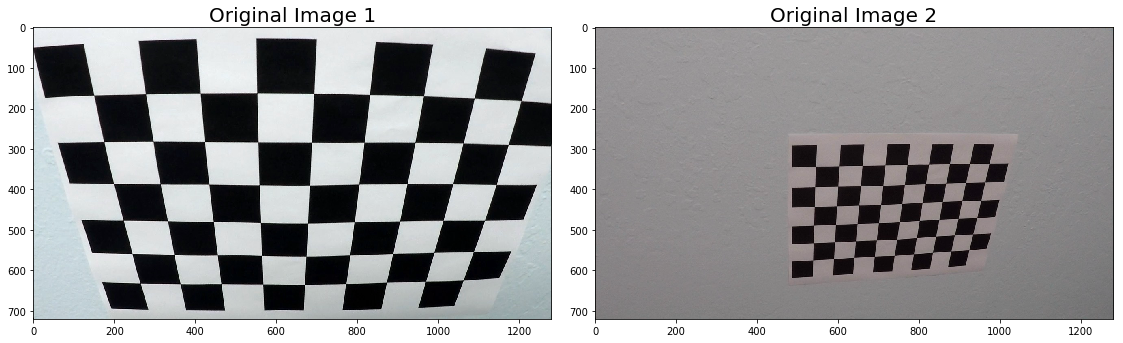

In [1286]:
## setting camera calibration image path
CAM_CAL_IMG_PATH = "./camera_cal/"

## read in the list of calibration images
camera_cal_list = os.listdir(CAM_CAL_IMG_PATH)
camera_cal_list = [CAM_CAL_IMG_PATH+imname for imname in camera_cal_list if imname != ".DS_Store"]

## show one of the calibration images
camera_cal_img_0 = cv2.imread(camera_cal_list[10])
camera_cal_img_1 = cv2.imread(camera_cal_list[0])

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(camera_cal_img_0)
ax1.set_title('Original Image 1', fontsize=20)

ax2.imshow(camera_cal_img_1)
ax2.set_title('Original Image 2', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/orig_distorted_img.png")

As seen in the above examples, the images are quite varied which allows us to correct for all types of images that the camera will eventually see.

Now, we can start to calibrate the camera. One way of doing this is to map points on the distorted image to an undistorted image (where we know all the location of those points, then we can transform or undistort the original image. In the case of using chessboards, the intersection of the black and white squares is a really good place to start.

We can use the OpenCV package to find these intersection points using the `findChessboardCorners` function [read more here](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findchessboardcorners). This will return a set of detected corner coordinates if the status is `1` or no corners if no corners could be found (status of `0`).

In [1287]:
## function for finding corners
def findCorners(img, nx=9, ny=6, draw=True):
    '''
    Inputs
    img: input chessboard image
    nx: number of inside corners on the x axis
    ny: number of inside corners on the y axis
    ---
    Returns
    matrix of corners if there were corners
    '''
    ## convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    ## if found, draw corners
    if ret == True:
        # Draw and display the corners
        if draw:
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

        return corners

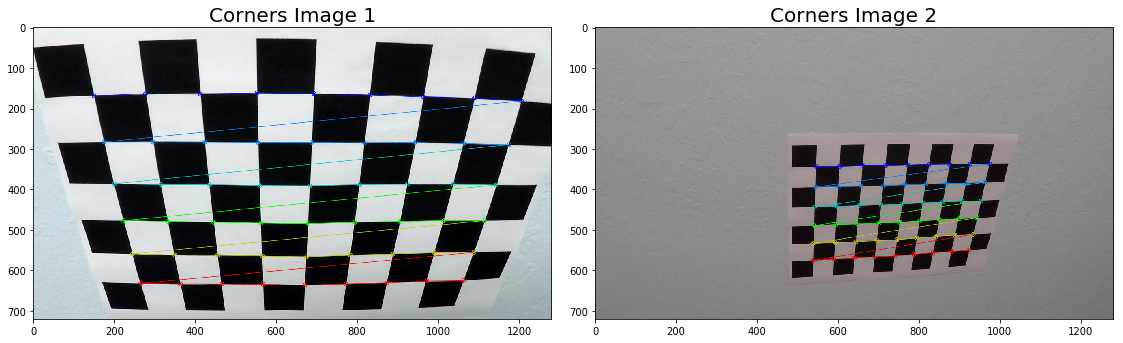

In [1288]:
## store found corners
corners_0 = findCorners(camera_cal_img_0)
corners_1 = findCorners(camera_cal_img_1)

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(camera_cal_img_0)
ax1.set_title('Corners Image 1', fontsize=20)

ax2.imshow(camera_cal_img_1)
ax2.set_title('Corners Image 2', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/corners_img.png")

As we can see, the function did a pretty good job of identifying the internal corners in the image of the chessboard. Now we need to undistort the image by using a mapping of these found corners our understanding of how a chessboard usually looks.

First we need to store these points so that we can use the points to undistort our images then we can calibrate the camera. The calibration step uses these object (actual flat chessboard) and image (distorted image) points to calculate a camera matrix, distortion matrix, and a couple other data points related to the position of the camera. We can use these outputs from the `calibrateCamera` function in the `undistort` function to undistort different images.

In [1289]:
## function for undistorting calibration images
def cal_undistort(img, objpoints_mat, imgpoints_mat):
    '''
    Inputs
    img: input chessboard image
    objpoints_mat: object points matrix (flat image)
    imgpoints_mat: actual image points matrix
    ---
    Returns
    undistorted image
    '''
    
    # use cv2.calibrateCamera() to calculate the data necessary for undistorting an image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints_mat, imgpoints_mat, img.shape[0:2], None, None)
    
    ## undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist

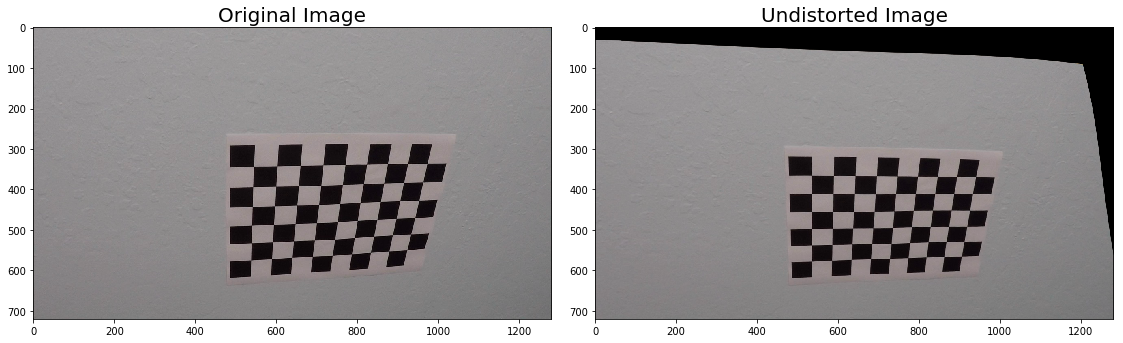

In [1290]:
## Read in an image
testimg = cv2.imread('./camera_cal/calibration10.jpg')

## prepare object points (representation of a chessboard with no distortion)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

## arrays to store object points and image points from all the images.
objpoints = [] # actual flat representation of points in a chessboard
imgpoints = [] # corners from distorted images
            
## find corners
corners_matrix = findCorners(testimg, draw=False)

if corners_matrix != None:
    objpoints.append(objp)
    imgpoints.append(corners_matrix)
    
## undistort the image
undistorted = cal_undistort(testimg, objpoints, imgpoints)

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/orig_undistorted_img.png")

Now, we can run the same thing over all of our images (usually it is recommended to use ~20 images for calibration of the camera)

In [1291]:
## prepare object points (representation of a chessboard with no distortion)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

## arrays to store object points and image points from all the images.
objpoints = [] # actual flat representation of points in a chessboard
imgpoints = [] # corners from distorted images
    
## iterate through different images
for img_path in camera_cal_list:
        
    ## read in image
    cal_img = cv2.imread(img_path)
    
    ## find corners
    corner_matrix = findCorners(cal_img, draw=False)
    
    if corner_matrix != None:
        objpoints.append(objp)
        imgpoints.append(corner_matrix)

In [1292]:
## camera calibration given all object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, testimg.shape[0:2], None, None)

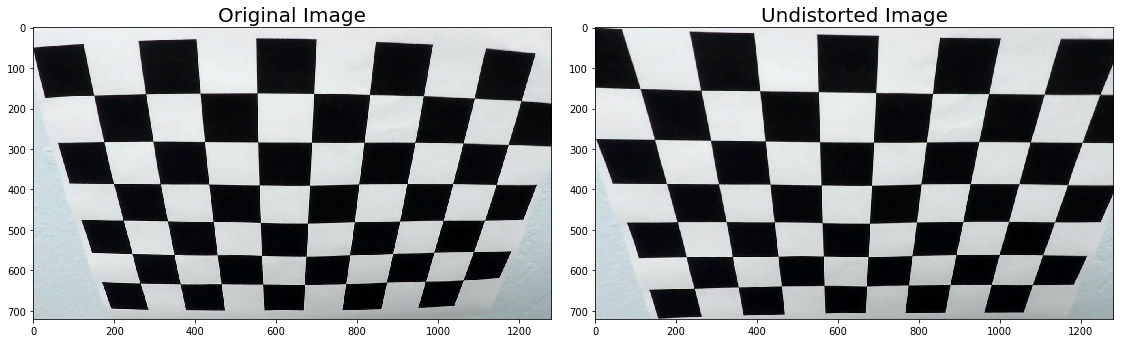

In [1293]:
## testing to see calibrated camera
cal_img = cv2.imread(camera_cal_list[10])

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(cal_img)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(cv2.undistort(cal_img, mtx, dist, None, mtx))
ax2.set_title('Undistorted Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/orig_undistorted_img_1.png")

Now with the camera matrix and the distortion matrix, we can apply the reverse distortion to the images from the forward facing camera from our car. We can take a look at an original image and an image that is corrected for the camera distortion.

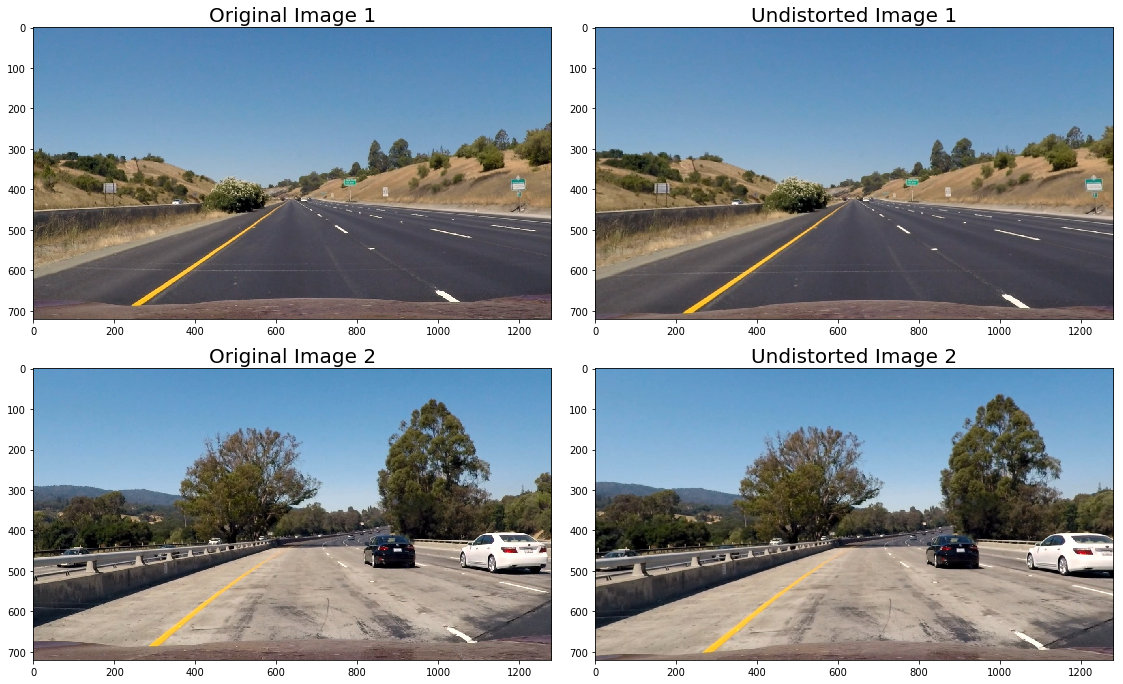

In [1294]:
## testing calibration on actual road images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(lane_img_1, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image 1', fontsize=20)

ax2.imshow(cv2.undistort(cv2.cvtColor(lane_img_1, cv2.COLOR_BGR2RGB), mtx, dist, None, mtx))
ax2.set_title('Undistorted Image 1', fontsize=20)

ax3.imshow(cv2.cvtColor(lane_img_2, cv2.COLOR_BGR2RGB))
ax3.set_title('Original Image 2', fontsize=20)

ax4.imshow(cv2.undistort(cv2.cvtColor(lane_img_2, cv2.COLOR_BGR2RGB), mtx, dist, None, mtx))
ax4.set_title('Undistorted Image 2', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/undistorted_lane_img.png")

From the above lane lines images, it might be slightly difficult to see the camera distortion change, but if we look at the hood of the car or the cars in the adjacent lanes you can see that the image indeed did become undistorted.

## Main Pipeline Functions
We can start buiding a pipeline (including the distortion correction above) to make it easier when we want to apply these functions to videos feeds later on.

In [1295]:
## raw image undistortion
def undistort_img(img, camera_matrix=mtx, distortion_matrix=dist):
    '''
    Inputs
    img: input chessboard image
    camera_matrix: output from OpenCV `calibrateCamera` function
    distortion_matrix: output from OpenCV `calibrateCamera` function
    ---
    Returns
    undistorted image
    '''
    ## using OpenCV's undistortion as before
    undist_img = cv2.undistort(img, camera_matrix, distortion_matrix, None, camera_matrix)
    
    return undist_img

## use sobel thresholding to image
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    ## convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ## take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    ## take the absolute value of the derivative or gradient
    abs_sobel = np.abs(sobel)
    
    # scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) 
    
    # create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

## magnitude of gradient thresholding
def magnitude_thresh(img, sobel_kernel=3, mag_thresh_input=(0, 255)):
    
    ## convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calculate the magnitude 
    sobelxy_mag = np.sqrt(sobelx**2 + sobely**2)
    
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobelxy_scaled = np.uint8(255*sobelxy_mag/np.max(sobelxy_mag))
    
    # create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(sobelxy_scaled)
    binary_output[(sobelxy_scaled >= mag_thresh_input[0]) & (sobelxy_scaled <= mag_thresh_input[1])] = 1
    
    return binary_output

## direction of gradient thresholding
def direction_thresh(img, sobel_kernel=3, dir_thresh_input=(0, np.pi/2)):
    
    ## convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    
    # create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= dir_thresh_input[0]) & (dir_grad <= dir_thresh_input[1])] = 1
    
    return binary_output

def combined_thresh(img, sobel_thresh=(20,100), sobel_kernel=3, 
                         mag_thresh=(30,100), dir_thresh=(0.7, 1.3)):
    
    ## convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 
    
    # create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_output_sobel = np.zeros_like(scaled_sobel)
    binary_output_sobel[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    
    # calculate the magnitude 
    sobelxy_mag = np.sqrt(sobelx**2 + sobely**2)
    
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobelxy_scaled = np.uint8(255*sobelxy_mag/np.max(sobelxy_mag))
    
    # create a binary mask where mag thresholds are met
    binary_output_mag = np.zeros_like(sobelxy_scaled)
    binary_output_mag[(sobelxy_scaled >= mag_thresh[0]) & (sobelxy_scaled <= mag_thresh[1])] = 1
    
#     # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
#     dir_grad = np.abs(np.arctan2(abs_sobely, abs_sobelx))
    
#     # create a binary mask where direction thresholds are met
#     binary_output_dir = np.zeros_like(dir_grad)
#     binary_output_dir[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    
#     ## combined binary with direction
#     combined = np.zeros_like(binary_output_dir)
#     combined[((binary_output_sobel == 1) | ((binary_output_mag == 1) & (binary_output_dir == 1)))] = 1

    black_color = cv2.inRange(hls_image, np.uint8([0,0,0]), np.uint8([75,255,255]))
    
    combined = np.zeros_like(binary_output_mag)
    combined[(((binary_output_sobel == 1) | (binary_output_mag == 1)) & (black_color != 1))] = 1
    
    return combined


## color selection for yellow and white, using the HLS and HSV color space
def color_thresh(img, color_thresh_input=(170, 255)):

    ## convert to HLS color space and separate the S channel
    hls_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
    ## convert to the HSV color space    
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    ## selecting colors yellow and white
    white_color = cv2.inRange(hls_image, np.uint8([10,200,0]), np.uint8([255,255,255]))
    yellow_color = cv2.inRange(hsv_image, np.uint8([15,60,130]), np.uint8([150,255,255]))
    
    ## combine yellow and white masks
    combined_color_images = cv2.bitwise_or(white_color, yellow_color)
    
    ## threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh_input[0]) & (s_channel <= color_thresh_input[1])] = 1

    ## threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 100) & (l_channel <= color_thresh_input[1])] = 1

    ## combined binaries
    combined_binary = np.zeros_like(s_channel)
    combined_binary[((s_binary > 0) & (l_binary > 0)) | (combined_color_images > 0)] = 1

    return combined_binary

## combine the different thresholding options
def threshold_pipeline(img, sobel_thresh=(40,100), sobel_kernel=3, mag_thresh=(30,100), 
                       dir_thresh=(0.7, 1.3), color_thresh_input=(170, 255)):
    
    ## denoise image
    img = cv2.fastNlMeansDenoisingColored(img,7,13,21,5)
    
    ## sobel, magnitude, direction threshold binary
    combined_thresh_binary = combined_thresh(img, sobel_thresh=(40,100), sobel_kernel=3, mag_thresh=(30,100), 
                       dir_thresh=(0.7, 1.3))
    
    ## color threshold binary
    color_thresh_binary = color_thresh(img, color_thresh_input=color_thresh_input)
    
    ## combine the binaries
    combined_binary = np.zeros_like(color_thresh_binary)
    combined_binary[(color_thresh_binary == 1) | (combined_thresh_binary == 1)] = 1
    
    return combined_binary
    
## transform image
def transform_image(img):
    
    ## define image shape
    img_size = (img.shape[1], img.shape[0])

    ## define source and destination points
    src = np.array([[205, 720], [1120, 720], [745, 480], [550, 480]], np.float32)
    dst = np.array([[205, 720], [1120, 720], [1120, 0], [205, 0]], np.float32)
    
    ## perform transformation
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

## final pipeline
def final_pipeline(img, camera_matrix=mtx, distortion_matrix=dist, sobel_thresh=(40,100), sobel_kernel=3, 
                   mag_thresh=(30,100), dir_thresh=(0.7, 1.3), color_thresh_input=(170, 255)):

    ## resize images to be same size as the training images (so that calibration matrix references same areas)
    img = cv2.resize(img, (1280, 720))

    ## apply distortion correction
    img = undistort_img(img, camera_matrix, distortion_matrix)

    ## create masked binary image using color threshold and transform image
    binary_img = color_thresh(transform_image(img)[0])
    
    return binary_img

## Detecting Lane Lines
Now that we have undistorted images, we can start to detect lane lines in the images. Ultimately, we would like to calculate the curvature of the lanes so that we can decide how to steer our car. 

In this section, we can use different color spaces, gradient, direction thresholding techniques to extract the lane lines. First of all, we can use different edge detection types of filter (similar to canny edge detection) such as the Sobel filter.

### Sobel Filter Thresholding

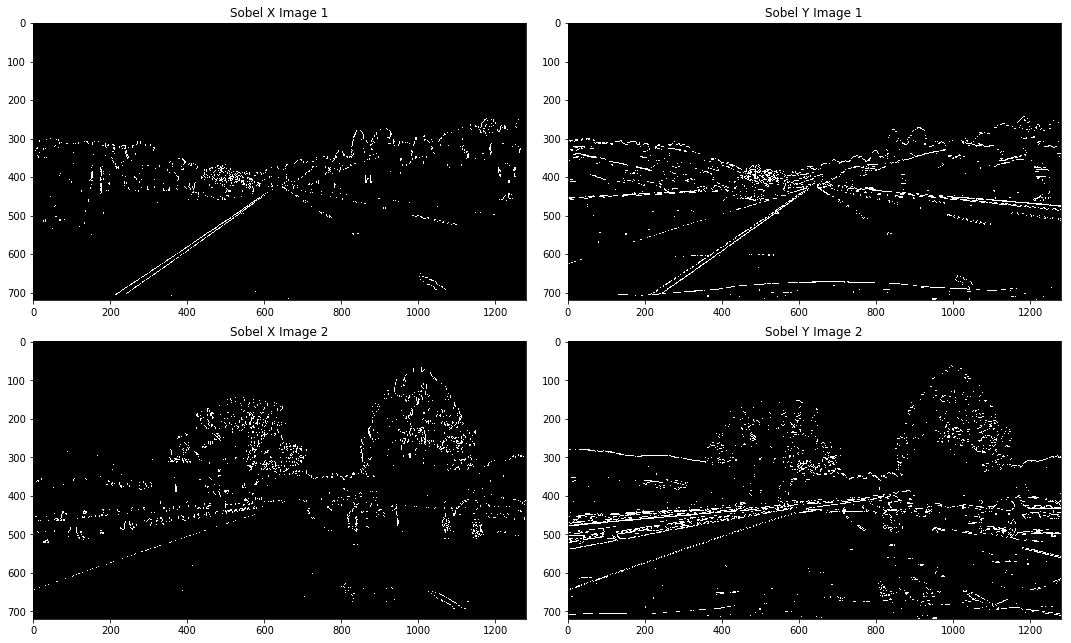

In [1334]:
## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_scaled_sx_1 = abs_sobel_thresh(lane_img_1, orient='x', thresh_min=40, thresh_max=100)
binary_scaled_sx_2 = abs_sobel_thresh(lane_img_2, orient='x', thresh_min=40, thresh_max=100)
binary_scaled_sy_1 = abs_sobel_thresh(lane_img_1, orient='y', thresh_min=40, thresh_max=100)
binary_scaled_sy_2 = abs_sobel_thresh(lane_img_2, orient='y', thresh_min=40, thresh_max=100)

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(binary_scaled_sx_1, cmap='gray')
ax1.set_title('Sobel X Image 1', fontsize=12)

ax2.imshow(binary_scaled_sy_1, cmap='gray')
ax2.set_title('Sobel Y Image 1', fontsize=12)

ax3.imshow(binary_scaled_sx_2, cmap='gray')
ax3.set_title('Sobel X Image 2', fontsize=12)

ax4.imshow(binary_scaled_sy_2, cmap='gray')
ax4.set_title('Sobel Y Image 2', fontsize=12)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/sobel_mask.png")

It seems like the x-axis definitely performs better for this task. It makes sense because the lane lines are typically vertical lines and the x-axis direction of the sobel filter highlights vertical lines (versus the y-axis direction highlights many of the horizontal elements of the image).

While in the example above the lane lines are pretty clearly identified, if we look at a harder example the result is not as clean.

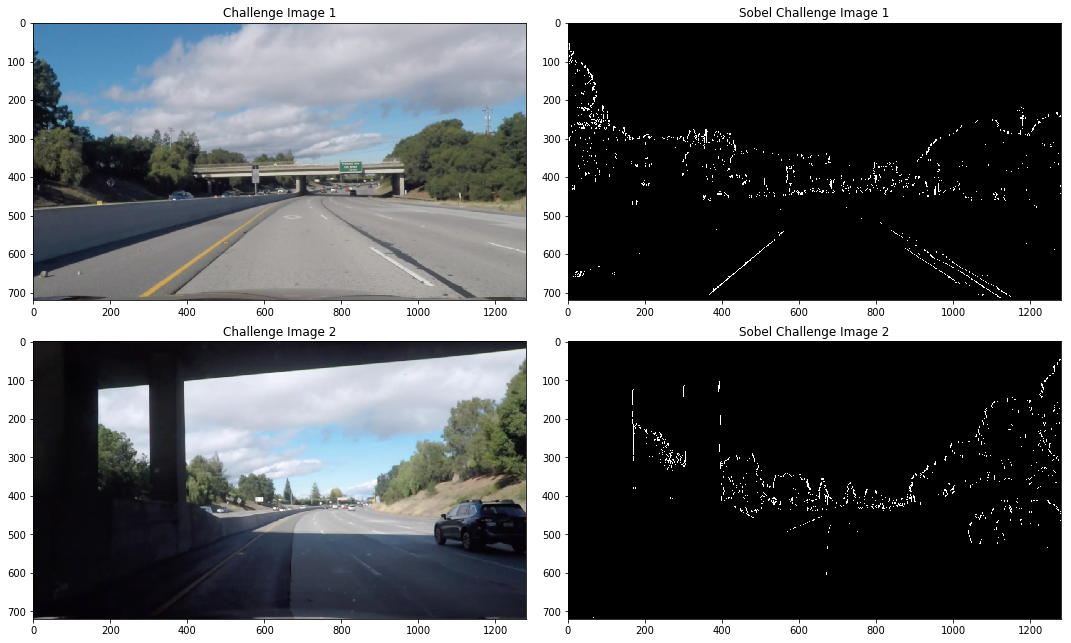

In [1336]:
## read in images
challenge_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')
challenge_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_4.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
challenge_img_1 = cv2.resize(challenge_img_1, (1280, 720))
challenge_img_2 = cv2.resize(challenge_img_2, (1280, 720))

## apply distortion correction
challenge_img_1 = undistort_img(challenge_img_1, mtx, dist)
challenge_img_2 = undistort_img(challenge_img_2, mtx, dist)

# create masked binary image (applying sobel filter along the x and y axis)
challenge_img_binary_1 = abs_sobel_thresh(challenge_img_1, orient='x', thresh_min=40, thresh_max=100)
challenge_img_binary_2 = abs_sobel_thresh(challenge_img_2, orient='x', thresh_min=40, thresh_max=100)

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(challenge_img_1, cv2.COLOR_BGR2RGB))
ax1.set_title('Challenge Image 1', fontsize=12)

ax2.imshow(challenge_img_binary_1, cmap='gray')
ax2.set_title('Sobel Challenge Image 1', fontsize=12)

ax3.imshow(cv2.cvtColor(challenge_img_2, cv2.COLOR_BGR2RGB))
ax3.set_title('Challenge Image 2', fontsize=12)

ax4.imshow(challenge_img_binary_2, cmap='gray')
ax4.set_title('Sobel Challenge Image 2', fontsize=12)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/challenge_sobel_mask.png")

Note that in the top example, we almost completely do not see the yellow lane line. Rather we capture the different colored pavement. In the bottom example, we also mainly capture the different pavement transition.

We can try to use other thresholding techniques (using color spaces) to identify the lane line even in situations where the we have anomalous aspects in the input image. 

### Magnitude of Gradient Thresholding

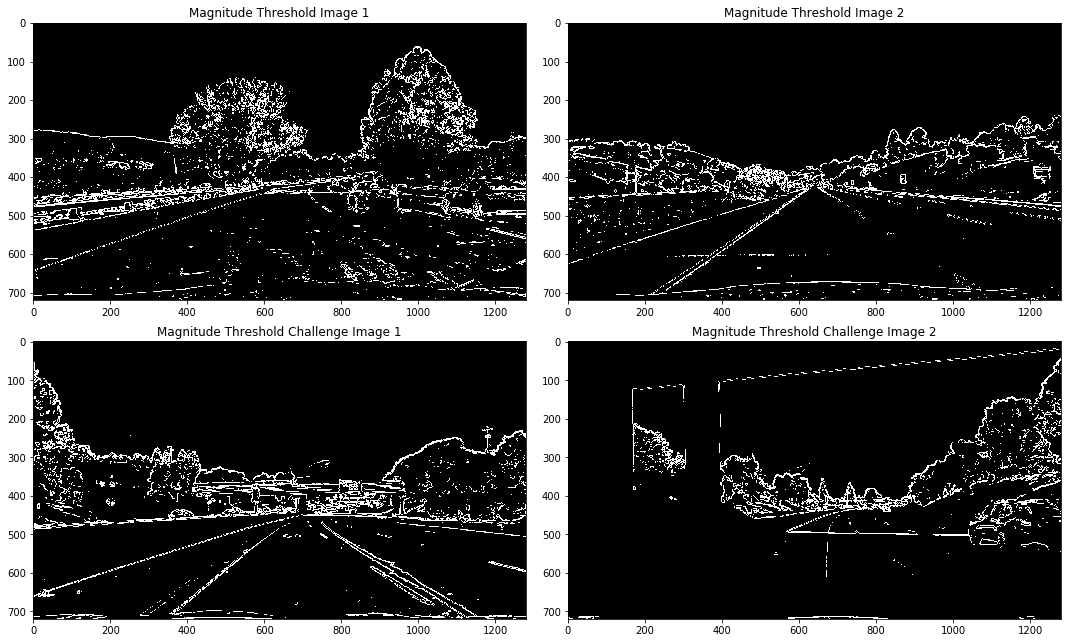

In [1337]:
thresh = (30,100)

## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')
lane_img_4 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_4.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
lane_img_3 = cv2.resize(lane_img_3, (1280, 720))
lane_img_4 = cv2.resize(lane_img_4, (1280, 720))

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)
lane_img_3 = undistort_img(lane_img_3, mtx, dist)
lane_img_4 = undistort_img(lane_img_4, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = magnitude_thresh(lane_img_1, mag_thresh_input=thresh)
binary_lane_img_2 = magnitude_thresh(lane_img_2, mag_thresh_input=thresh)
binary_lane_img_3 = magnitude_thresh(lane_img_3, mag_thresh_input=thresh)
binary_lane_img_4 = magnitude_thresh(lane_img_4, mag_thresh_input=thresh)

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(binary_lane_img_1, cmap='gray')
ax1.set_title('Magnitude Threshold Image 1', fontsize=12)

ax2.imshow(binary_lane_img_2, cmap='gray')
ax2.set_title('Magnitude Threshold Image 2', fontsize=12)

ax3.imshow(binary_lane_img_3, cmap='gray')
ax3.set_title('Magnitude Threshold Challenge Image 1', fontsize=12)

ax4.imshow(binary_lane_img_4, cmap='gray')
ax4.set_title('Magnitude Threshold Challenge Image 2', fontsize=12)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/mag_mask.png")

### Direction of Gradient Thresholding

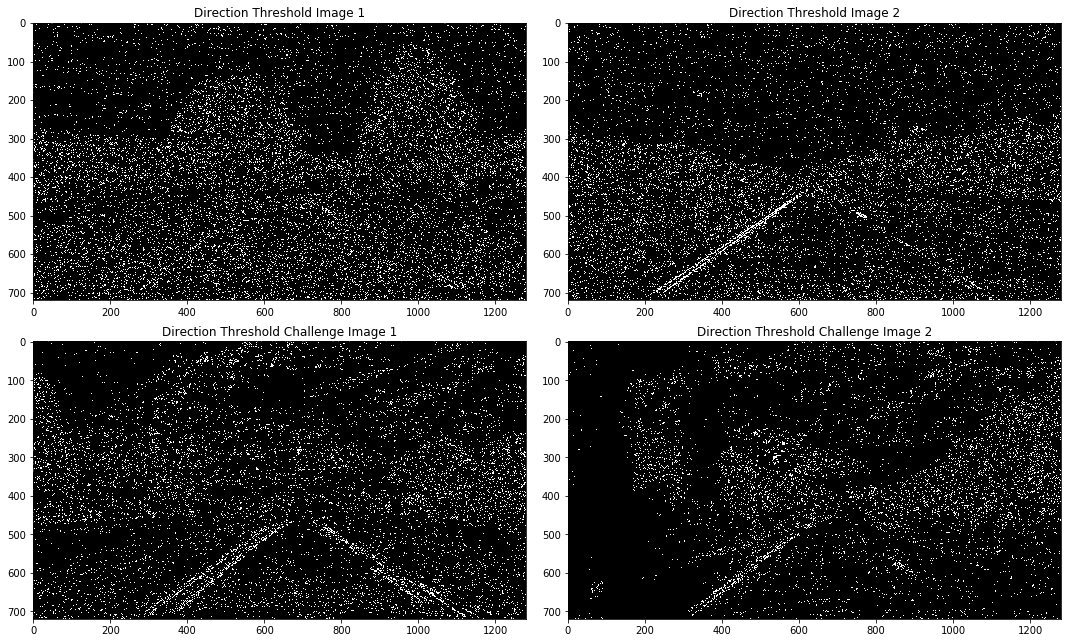

In [1338]:
thresh = (0.85,1.05)

## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')
lane_img_4 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_4.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
lane_img_3 = cv2.resize(lane_img_3, (1280, 720))
lane_img_4 = cv2.resize(lane_img_4, (1280, 720))

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)
lane_img_3 = undistort_img(lane_img_3, mtx, dist)
lane_img_4 = undistort_img(lane_img_4, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = direction_thresh(lane_img_1, dir_thresh_input=thresh)
binary_lane_img_2 = direction_thresh(lane_img_2, dir_thresh_input=thresh)
binary_lane_img_3 = direction_thresh(lane_img_3, dir_thresh_input=thresh)
binary_lane_img_4 = direction_thresh(lane_img_4, dir_thresh_input=thresh)

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(binary_lane_img_1, cmap='gray')
ax1.set_title('Direction Threshold Image 1', fontsize=12)

ax2.imshow(binary_lane_img_2, cmap='gray')
ax2.set_title('Direction Threshold Image 2', fontsize=12)

ax3.imshow(binary_lane_img_3, cmap='gray')
ax3.set_title('Direction Threshold Challenge Image 1', fontsize=12)

ax4.imshow(binary_lane_img_4, cmap='gray')
ax4.set_title('Direction Threshold Challenge Image 2', fontsize=12)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/dir_mask.png")

### Combined Thresholding

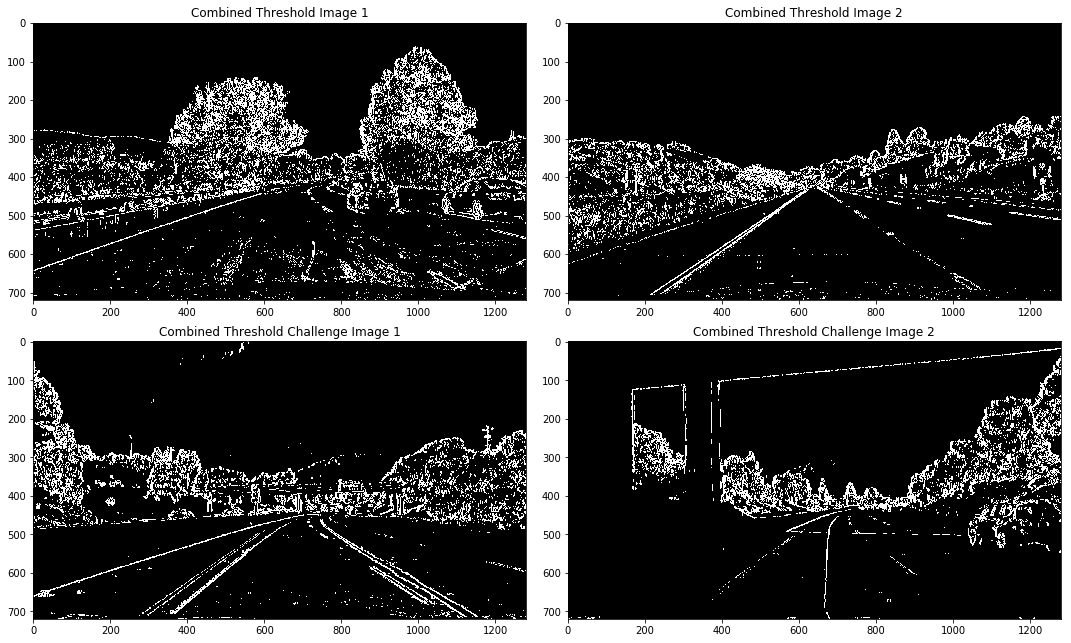

In [1339]:
sobel_thresh = (12,100)
mag_thresh = (80,100)
dir_thresh = (0.85,1.05)

## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')
lane_img_4 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_4.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
lane_img_3 = cv2.resize(lane_img_3, (1280, 720))
lane_img_4 = cv2.resize(lane_img_4, (1280, 720))

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)
lane_img_3 = undistort_img(lane_img_3, mtx, dist)
lane_img_4 = undistort_img(lane_img_4, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = combined_thresh(lane_img_1, sobel_thresh=sobel_thresh, mag_thresh=mag_thresh, dir_thresh=dir_thresh)
binary_lane_img_2 = combined_thresh(lane_img_2, sobel_thresh=sobel_thresh, mag_thresh=mag_thresh, dir_thresh=dir_thresh)
binary_lane_img_3 = combined_thresh(lane_img_3, sobel_thresh=sobel_thresh, mag_thresh=mag_thresh, dir_thresh=dir_thresh)
binary_lane_img_4 = combined_thresh(lane_img_4, sobel_thresh=sobel_thresh, mag_thresh=mag_thresh, dir_thresh=dir_thresh)

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(binary_lane_img_1, cmap='gray')
ax1.set_title('Combined Threshold Image 1', fontsize=12)

ax2.imshow(binary_lane_img_2, cmap='gray')
ax2.set_title('Combined Threshold Image 2', fontsize=12)

ax3.imshow(binary_lane_img_3, cmap='gray')
ax3.set_title('Combined Threshold Challenge Image 1', fontsize=12)

ax4.imshow(binary_lane_img_4, cmap='gray')
ax4.set_title('Combined Threshold Challenge Image 2', fontsize=12)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/combined_mask.png")

Taking a look at the above output, it seems like the combined thresholding does relatively well on the simple examples, but there are still difficulties with the challenge images. Note that the noise in the rest of the image will be masked away later so we can just aim to better highlight the lane lines using color thresholding.

### Color Thresholding

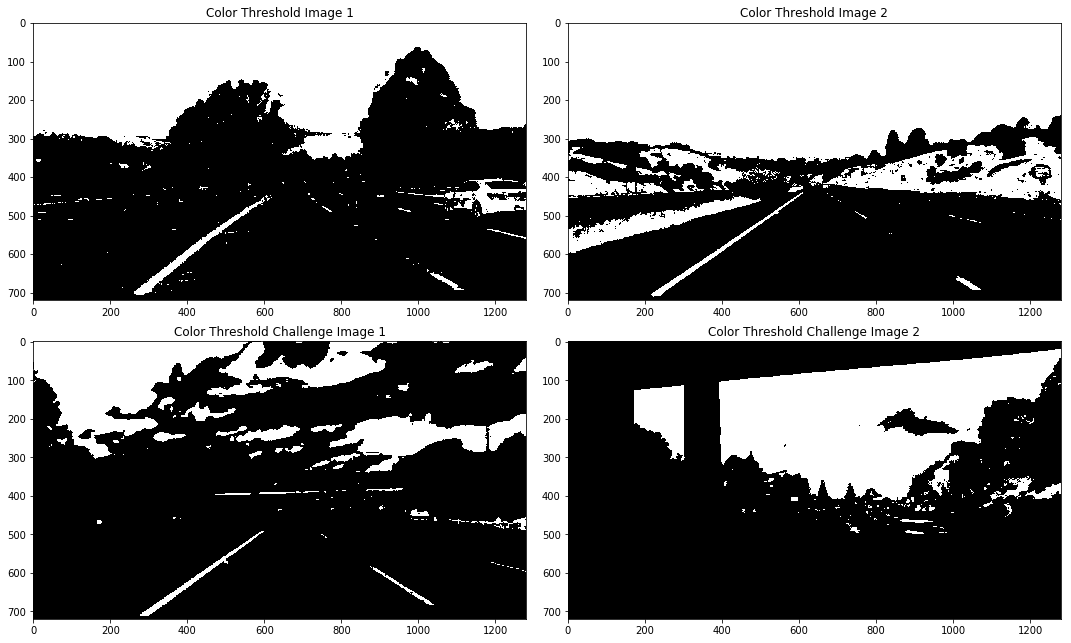

In [1341]:
thresh = (170, 255)

## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')
lane_img_4 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_4.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
lane_img_3 = cv2.resize(lane_img_3, (1280, 720))
lane_img_4 = cv2.resize(lane_img_4, (1280, 720))

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)
lane_img_3 = undistort_img(lane_img_3, mtx, dist)
lane_img_4 = undistort_img(lane_img_4, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = color_thresh(lane_img_1, color_thresh_input=thresh)
binary_lane_img_2 = color_thresh(lane_img_2, color_thresh_input=thresh)
binary_lane_img_3 = color_thresh(lane_img_3, color_thresh_input=thresh)
binary_lane_img_4 = color_thresh(lane_img_4, color_thresh_input=thresh)

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(binary_lane_img_1, cmap='gray')
ax1.set_title('Color Threshold Image 1', fontsize=12)

ax2.imshow(binary_lane_img_2, cmap='gray')
ax2.set_title('Color Threshold Image 2', fontsize=12)

ax3.imshow(binary_lane_img_3, cmap='gray')
ax3.set_title('Color Threshold Challenge Image 1', fontsize=12)

ax4.imshow(binary_lane_img_4, cmap='gray')
ax4.set_title('Color Threshold Challenge Image 2', fontsize=12)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/color_mask.png")

We will need to adjust the threshold or figure out a different color space to use in order to better capture the challenge image lane lines.

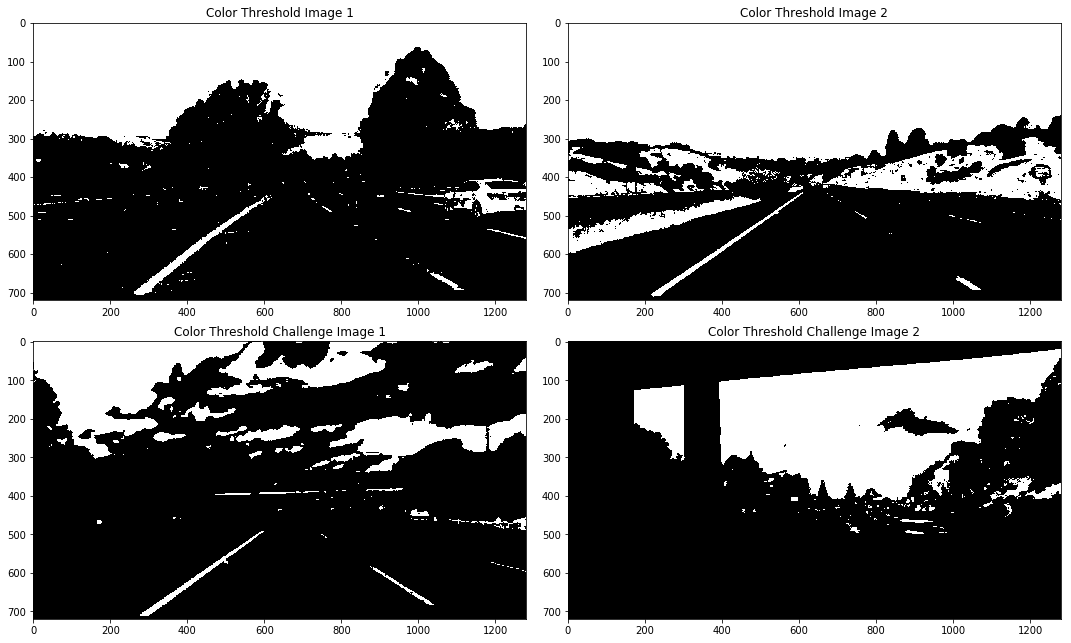

In [1342]:
## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')
lane_img_4 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_4.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
lane_img_3 = cv2.resize(lane_img_3, (1280, 720))
lane_img_4 = cv2.resize(lane_img_4, (1280, 720))

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)
lane_img_3 = undistort_img(lane_img_3, mtx, dist)
lane_img_4 = undistort_img(lane_img_4, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = color_thresh(lane_img_1)
binary_lane_img_2 = color_thresh(lane_img_2)
binary_lane_img_3 = color_thresh(lane_img_3)
binary_lane_img_4 = color_thresh(lane_img_4)

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(binary_lane_img_1, cmap='gray')
ax1.set_title('Color Threshold Image 1', fontsize=12)

ax2.imshow(binary_lane_img_2, cmap='gray')
ax2.set_title('Color Threshold Image 2', fontsize=12)

ax3.imshow(binary_lane_img_3, cmap='gray')
ax3.set_title('Color Threshold Challenge Image 1', fontsize=12)

ax4.imshow(binary_lane_img_4, cmap='gray')
ax4.set_title('Color Threshold Challenge Image 2', fontsize=12)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/color_mask_1.png")

Using the improved color selection (both the HSV and the HSL color spaces) it seems like the thresholding on color now works fairly well! Now we can try and combine the different thresholding techniques.

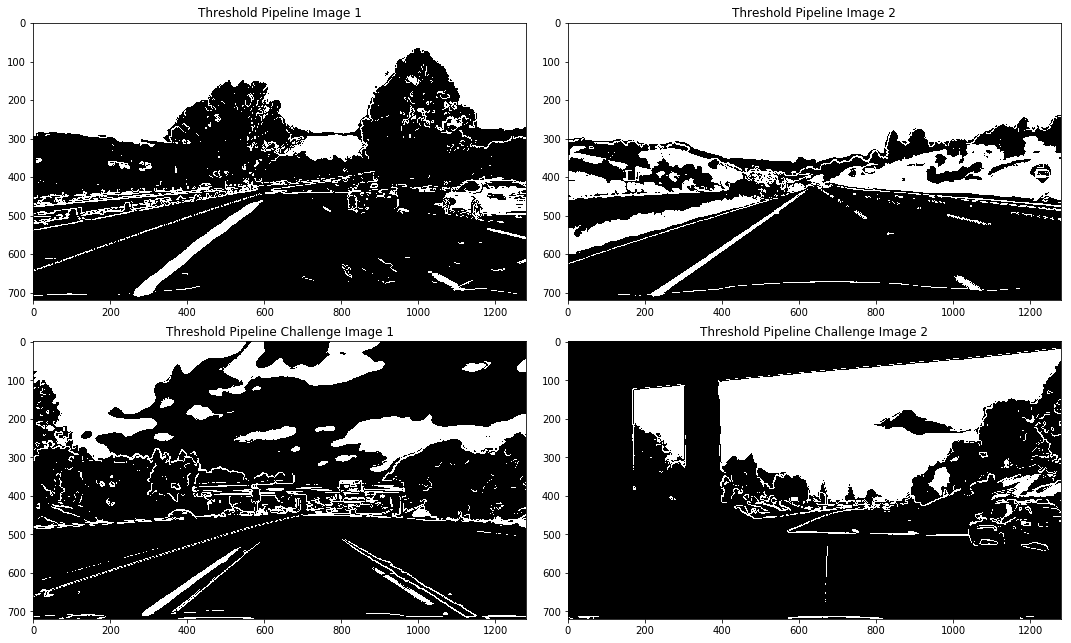

In [1344]:
## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')
lane_img_4 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_4.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
lane_img_3 = cv2.resize(lane_img_3, (1280, 720))
lane_img_4 = cv2.resize(lane_img_4, (1280, 720))

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)
lane_img_3 = undistort_img(lane_img_3, mtx, dist)
lane_img_4 = undistort_img(lane_img_4, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = threshold_pipeline(lane_img_1)
binary_lane_img_2 = threshold_pipeline(lane_img_2)
binary_lane_img_3 = threshold_pipeline(lane_img_3)
binary_lane_img_4 = threshold_pipeline(lane_img_4)

## plot the images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(binary_lane_img_1, cmap='gray')
ax1.set_title('Threshold Pipeline Image 1', fontsize=12)

ax2.imshow(binary_lane_img_2, cmap='gray')
ax2.set_title('Threshold Pipeline Image 2', fontsize=12)

ax3.imshow(binary_lane_img_3, cmap='gray')
ax3.set_title('Threshold Pipeline Challenge Image 1', fontsize=12)

ax4.imshow(binary_lane_img_4, cmap='gray')
ax4.set_title('Threshold Pipeline Challenge Image 2', fontsize=12)

# plt.subplots_adjust(left=1., right=1., top=2., bottom=1.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/threshold_pipeline.png")

Not too bad! There is a lot of noise that is introduced because of the non-color thresholding. We can see if it makes sense to refine this further later on. 

Now we can think about how to adjust the perspective of the image so that we can detect the curvature of the lane lines. One way of doing this is to take a birds eye view of the picture (from the top down). In order to do this, we can use the `getPerspectiveTransform` and `warpPerspective` functions in OpenCV. 

### Perspective Transform

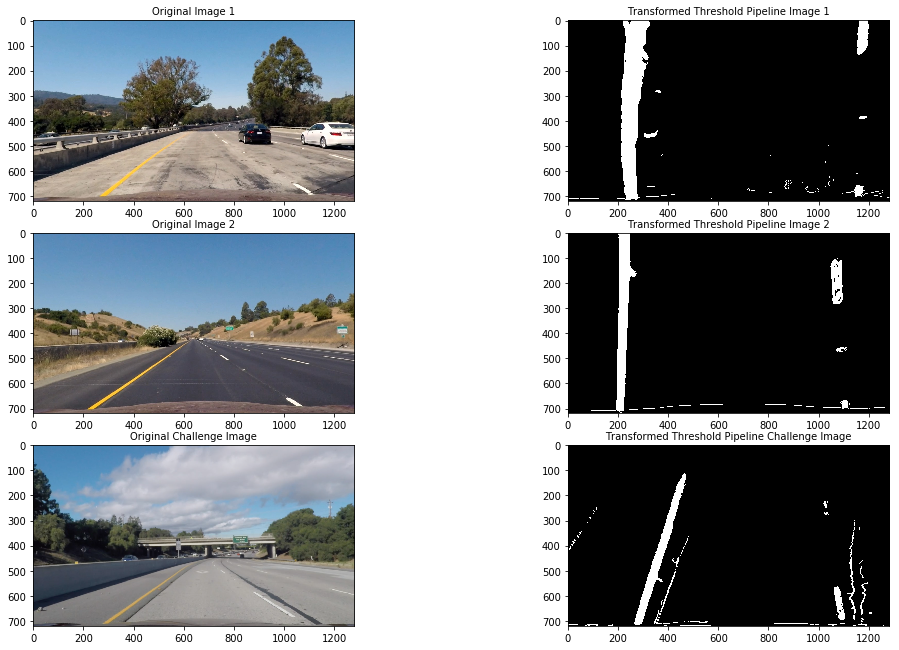

In [1345]:
## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
lane_img_3 = cv2.resize(lane_img_3, (1280, 720))

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)
lane_img_3 = undistort_img(lane_img_3, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = threshold_pipeline(transform_image(lane_img_1)[0])
binary_lane_img_2 = threshold_pipeline(transform_image(lane_img_2)[0])
binary_lane_img_3 = threshold_pipeline(transform_image(lane_img_3)[0])

## plot the images
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(lane_img_1, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image 1', fontsize=10)

ax2.imshow(binary_lane_img_1, cmap='gray')
ax2.set_title('Transformed Threshold Pipeline Image 1', fontsize=10)

ax3.imshow(cv2.cvtColor(lane_img_2, cv2.COLOR_BGR2RGB))
ax3.set_title('Original Image 2', fontsize=10)

ax4.imshow(binary_lane_img_2, cmap='gray')
ax4.set_title('Transformed Threshold Pipeline Image 2', fontsize=10)

ax5.imshow(cv2.cvtColor(lane_img_3, cv2.COLOR_BGR2RGB))
ax5.set_title('Original Challenge Image', fontsize=10)

ax6.imshow(binary_lane_img_3, cmap='gray')
ax6.set_title('Transformed Threshold Pipeline Challenge Image', fontsize=10)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/warped_1.png")

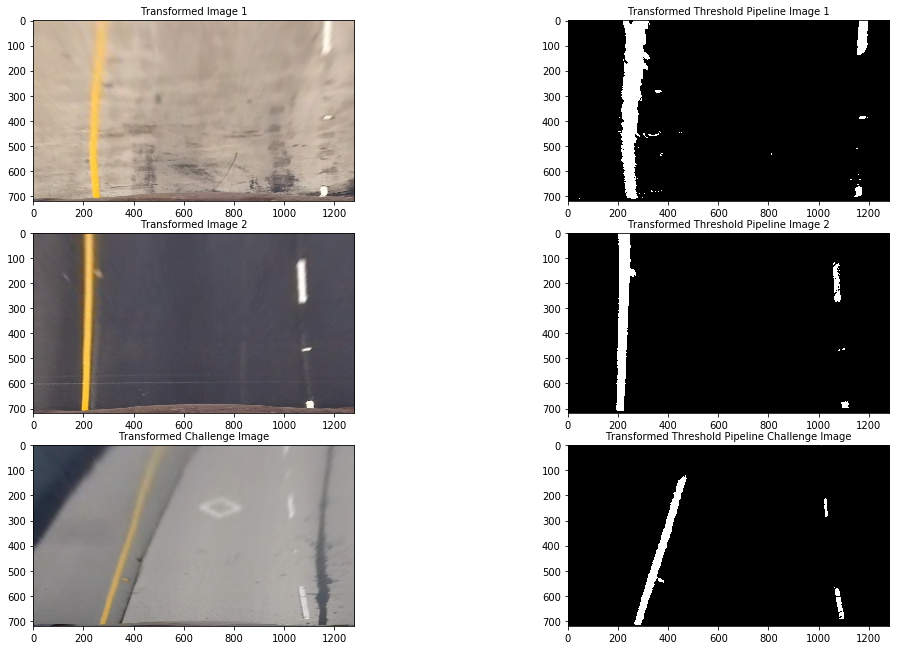

In [1346]:
## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test1.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/straight_lines1.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
lane_img_3 = cv2.resize(lane_img_3, (1280, 720))

## apply distortion correction
lane_img_1 = undistort_img(lane_img_1, mtx, dist)
lane_img_2 = undistort_img(lane_img_2, mtx, dist)
lane_img_3 = undistort_img(lane_img_3, mtx, dist)

## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = color_thresh(transform_image(lane_img_1)[0])
binary_lane_img_2 = color_thresh(transform_image(lane_img_2)[0])
binary_lane_img_3 = color_thresh(transform_image(lane_img_3)[0])

## plot the images
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(transform_image(lane_img_1)[0], cv2.COLOR_BGR2RGB))
ax1.set_title('Transformed Image 1', fontsize=10)

ax2.imshow(binary_lane_img_1, cmap='gray')
ax2.set_title('Transformed Threshold Pipeline Image 1', fontsize=10)

ax3.imshow(cv2.cvtColor(transform_image(lane_img_2)[0], cv2.COLOR_BGR2RGB))
ax3.set_title('Transformed Image 2', fontsize=10)

ax4.imshow(binary_lane_img_2, cmap='gray')
ax4.set_title('Transformed Threshold Pipeline Image 2', fontsize=10)

ax5.imshow(cv2.cvtColor(transform_image(lane_img_3)[0], cv2.COLOR_BGR2RGB))
ax5.set_title('Transformed Challenge Image', fontsize=10)

ax6.imshow(binary_lane_img_3, cmap='gray')
ax6.set_title('Transformed Threshold Pipeline Challenge Image', fontsize=10)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/transformed_1.png")

So the transform seemed to work quite well, but if we compare it to just using the color threshold it seems like the color threshold is better than the total combined threshold (we might switch back to just the color threshold later).

Note that it yielded better results when we first transformed before doing the thresholding. Below is a sample of the iterative code that I used to find the right coordinates for the perspective transform. It helped a lot to plot a polygon to help visualize the transform.

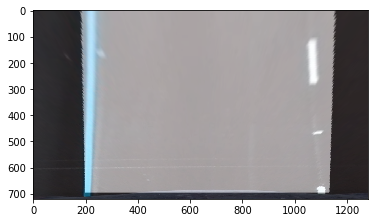

In [1316]:
## use the transform and a polygon to figure out the right dimensions for source
testimg = lane_img_2.copy()

## create mask on which to plot polygon
mask = np.zeros_like(testimg)
poly = np.array([[(575,460),(720,460),(1075,685),(250,685)]], np.int32)

cv2.fillPoly(mask, poly, (255,)*3)

## create overlayed image
cv2.addWeighted(mask, 0.5, testimg, 0.5,0, testimg)

plt.imshow(transform_image(testimg)[0])

### Sliding Window Search and Polynomial Line Fitting
Next we can try to figure out where the lane lines are and how much curvature are in the lane lines. In order to find the lane lines, we can create a histogram with the columns of the image intensities summed together. This would return higher values for areas where there are higher intensities (lane lines).

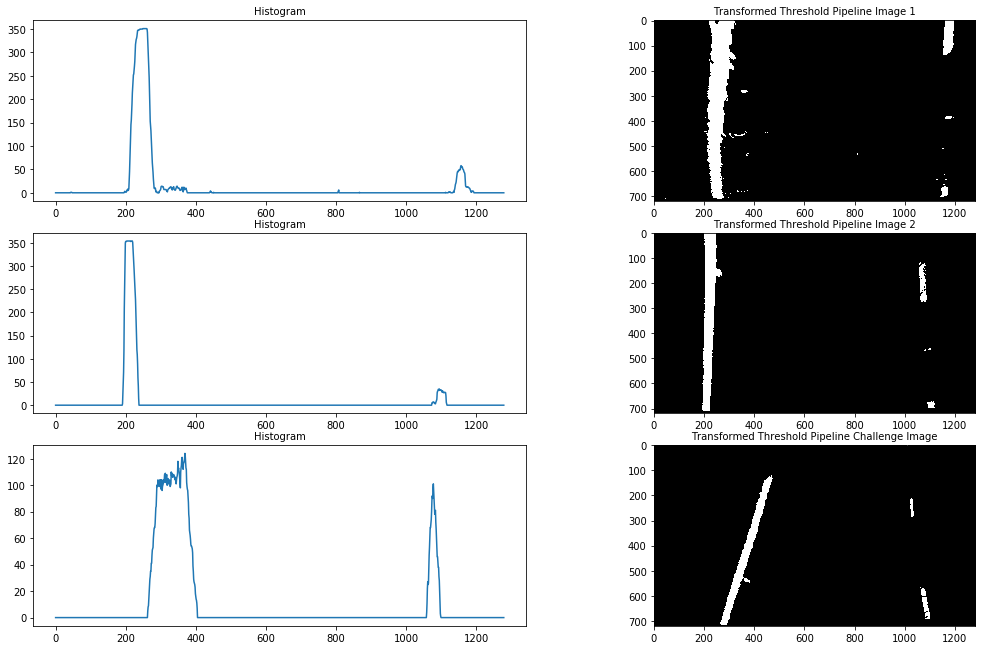

In [1347]:
## create masked binary image (applying sobel filter along the x and y axis)
binary_lane_img_1 = color_thresh(transform_image(lane_img_1)[0])
binary_lane_img_2 = color_thresh(transform_image(lane_img_2)[0])
binary_lane_img_3 = color_thresh(transform_image(lane_img_3)[0])

## create histograms
binary_lane_img_1_hist = np.sum(binary_lane_img_1[binary_lane_img_1.shape[0]//2:,:], axis=0)
binary_lane_img_2_hist = np.sum(binary_lane_img_2[binary_lane_img_2.shape[0]//2:,:], axis=0)
binary_lane_img_3_hist = np.sum(binary_lane_img_3[binary_lane_img_3.shape[0]//2:,:], axis=0)


## plot the image
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 9))
f.tight_layout()

ax1.plot(binary_lane_img_1_hist)
ax1.set_title('Histogram', fontsize=10)

ax2.imshow(binary_lane_img_1, cmap='gray')
ax2.set_title('Transformed Threshold Pipeline Image 1', fontsize=10)

ax3.plot(binary_lane_img_2_hist)
ax3.set_title('Histogram', fontsize=10)

ax4.imshow(binary_lane_img_2, cmap='gray')
ax4.set_title('Transformed Threshold Pipeline Image 2', fontsize=10)

ax5.plot(binary_lane_img_3_hist)
ax5.set_title('Histogram', fontsize=10)

ax6.imshow(binary_lane_img_3, cmap='gray')
ax6.set_title('Transformed Threshold Pipeline Challenge Image', fontsize=10)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/histogram.png")

The histogram technique worked fairly well but if we take a closer look we the lane lines (unless they are perfectly straight) will be diagonal across the image. Therefore, it would be best to take a window approach to look at segments of the image (or horizontal bands) in order to be able to capture the curvature of the lanes.

In [1318]:
## function to create sliding window histogram
def sliding_window_hist(bin_img):
    
    ## set middle buffer to not consider
    mid_buffer = 175
    
    ## take a histogram of the bottom half of the image
    histogram = np.sum(bin_img[bin_img.shape[0]//3:,:], axis=0)

    ## find the peak of the left and right halves of the histogram
    ## these will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint-mid_buffer])
    rightx_base = np.argmax(histogram[midpoint+mid_buffer:]) + midpoint + mid_buffer

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(bin_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 85
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    ## save rectangles
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bin_img.shape[0] - (window+1)*window_height
        win_y_high = bin_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # save the windows on the visualization image
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles

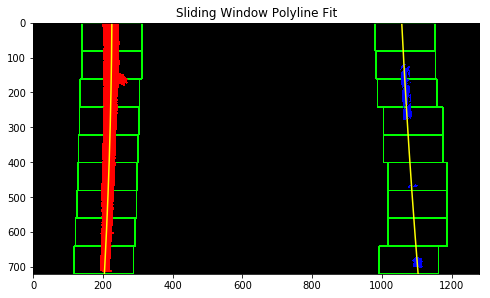

In [1320]:
## image to test on
bin_img = binary_lane_img_2

## create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((bin_img, bin_img, bin_img))*255)

## extract sliding window data
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(bin_img)

## create polyfit lines
ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Draw the rectangles on image
for rect in rectangles:
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 3) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 3) 

nonzero = bin_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
    
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(8,12))
plt.imshow(out_img)
plt.title("Sliding Window Polyline Fit")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## save image for write up
# plt.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/sliding_window_fit.png")

In the above example, we can see that the lane lines are quite well defined and the fitted line is also quite accurate! Next, we define a new function that can take in the fit of the last frame (of a video, if there is one) and search only in an area that is close to the previous image's lane lines.

In [1321]:
## function for searching a subsequent frame of a video
def sliding_window_hist_next(bin_img, left_fit_prev, right_fit_prev):
    
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ## area to search
    margin = 85

    ## left and right lane pixels
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ## only fit poly line if there are identified pixels
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

If we look through the test images that we have, it seems like `test6`, `test5`, and `test4` are sequential images so we can use these images to test out the function above.  

In [1322]:
## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test6.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test4.jpg')
lane_img_3 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test5.jpg')

## resize images to be same size as the training images (so that calibration matrix references same areas)
binary_lane_img_1 = cv2.resize(lane_img_1, (1280, 720))
binary_lane_img_2 = cv2.resize(lane_img_2, (1280, 720))
binary_lane_img_3 = cv2.resize(lane_img_3, (1280, 720))

## apply distortion correction
binary_lane_img_1 = undistort_img(binary_lane_img_1, mtx, dist)
binary_lane_img_2 = undistort_img(binary_lane_img_2, mtx, dist)
binary_lane_img_3 = undistort_img(binary_lane_img_3, mtx, dist)

## create masked binary image using color threshold and transform image
binary_lane_img_1, M_1, Minv_1 = transform_image(binary_lane_img_1)
binary_lane_img_2, M_2, Minv_2 = transform_image(binary_lane_img_2)
binary_lane_img_3, M_3, Minv_3 = transform_image(binary_lane_img_3)

## apply threshold
binary_lane_img_1 = color_thresh(binary_lane_img_1)
binary_lane_img_2 = color_thresh(binary_lane_img_2)
binary_lane_img_3 = color_thresh(binary_lane_img_3)

## first find poly lines in first frame of sequence
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_lane_img_1)

left_fit_next, right_fit_next, left_lane_inds_next, right_lane_inds_next = sliding_window_hist_next(binary_lane_img_2, 
                                                                                                   left_fit, right_fit)

(720, 0)

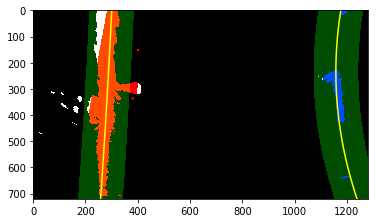

In [1323]:
## visualize new fitted lines
# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((binary_lane_img_2, binary_lane_img_2, binary_lane_img_2))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = binary_lane_img_2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds_next], nonzerox[left_lane_inds_next]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_next], nonzerox[right_lane_inds_next]] = [0, 0, 255]

## margin
margin = 85

## create fitted lines
ploty = np.linspace(0, binary_lane_img_2.shape[0]-1, binary_lane_img_2.shape[0] )
left_fitx_next = left_fit_next[0]*ploty**2 + left_fit_next[1]*ploty + left_fit_next[2]
right_fitx_next = right_fit_next[0]*ploty**2 + right_fit_next[1]*ploty + right_fit_next[2]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx_next-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx_next+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx_next-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx_next+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx_next, ploty, color='yellow')
plt.plot(right_fitx_next, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

The shaded area represents the new region that the next image was searched to find the lane lines. This reduces the need to search through the entire image for the lane lines again. With these fitted lines, we can now work try and figure out the radius of the curvature in the lane, which will ultimately help us figure out how much we need to steer the vehicle.

In [1324]:
## radius and distance from center function
def curvature_dist(bin_img, left_lane_idx, right_lane_idx):
    
    ## define range
    ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0])
    
    ## max y
    y_eval = np.max(ploty)

    # find nonzero pixels
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_idx]
    lefty = nonzeroy[left_lane_idx] 
    rightx = nonzerox[right_lane_idx]
    righty = nonzeroy[right_lane_idx]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_curve = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_curve = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_radius = ((1 + (2*left_fit_curve[0]*y_eval*ym_per_pix + left_fit_curve[1])**2)**1.5) / np.absolute(2*left_fit_curve[0])
    right_radius = ((1 + (2*right_fit_curve[0]*y_eval*ym_per_pix + right_fit_curve[1])**2)**1.5) / np.absolute(2*right_fit_curve[0])
    
    ## distance from center
    center_idx = bin_img.shape[1]//2
    identified_lanes_center_idx = (min(leftx) + max(rightx))//2
    
    dist_from_cent = np.abs(center_idx - identified_lanes_center_idx)*xm_per_pix
    
    return np.array([left_radius, right_radius, dist_from_cent])
    

In [1325]:
## calculate curvature of the lanes
curvature_dist(binary_lane_img_3, left_lane_inds_3, right_lane_inds_3)

array([ 117.93855342,   87.44364645,    0.12333333])

In [1326]:
## draw lane area
def fill_area(img, bin_img, left_fit_poly, right_fit_poly, inverse_matrix):
    
    ## create copy of image
    img_copy = np.copy(cv2.resize(img, (1280, 720)))
    
    ## define range
    ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ## fit lines
    left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
    right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverse_matrix, (img_copy.shape[1], img_copy.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_copy, 1, newwarp, 0.3, 0)
    
    return result

## write info about curvature
def write_info(area_img, curvature_output):
    
    ## copy area image
    area_img_copy = np.copy(area_img)
    
    ## format text for overlay
    left_text = "Left Curve Radius: {0:.2f}m".format(curvature_output[0])
    right_text = "Right Curve Radius: {0:.2f}m".format(curvature_output[1])
    dist_text = "Distance from Center: {0:.2f}m".format(curvature_output[2])
    
    ## area_img writing
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(area_img_copy, left_text, (60,90), font, 1.25, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(area_img_copy, right_text, (60,140), font, 1.25, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(area_img_copy, dist_text, (60,190), font, 1.25, (255,255,255), 2, cv2.LINE_AA)

    return area_img_copy

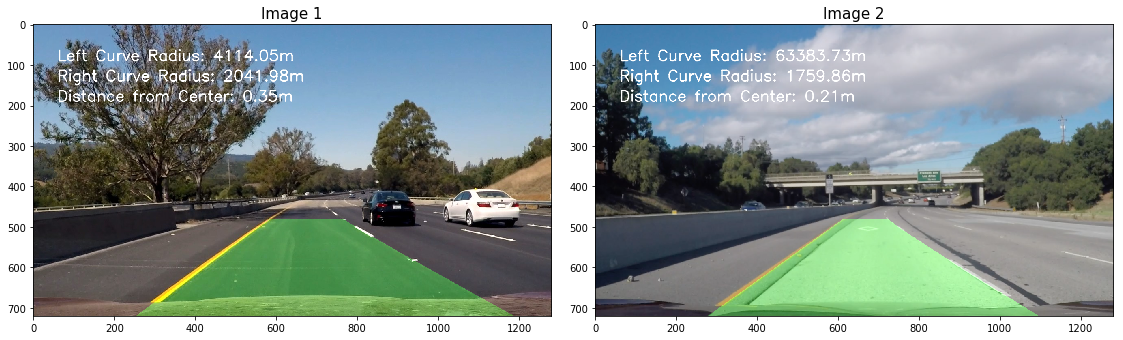

In [1328]:
## read in lane images
lane_img_1 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/test6.jpg')
lane_img_2 = cv2.imread('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/challenge_2.png')

## resize images to be same size as the training images (so that calibration matrix references same areas)
binary_lane_img_1 = cv2.resize(lane_img_1, (1280, 720))
binary_lane_img_2 = cv2.resize(lane_img_2, (1280, 720))

## apply distortion correction
binary_lane_img_1 = undistort_img(binary_lane_img_1, mtx, dist)
binary_lane_img_2 = undistort_img(binary_lane_img_2, mtx, dist)

## create masked binary image using color threshold and transform image
binary_lane_img_1, M_1, Minv_1 = transform_image(binary_lane_img_1)
binary_lane_img_2, M_2, Minv_2 = transform_image(binary_lane_img_2)

## apply threshold
binary_lane_img_1 = color_thresh(binary_lane_img_1)
binary_lane_img_2 = color_thresh(binary_lane_img_2)

## first find poly lines in first frame of sequence
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_lane_img_1)
left_fit_2, right_fit_2, left_lane_inds_2, right_lane_inds_2, rectangles_2 = sliding_window_hist(binary_lane_img_2)

## draw lane area
new_img_1 = fill_area(lane_img_1, binary_lane_img_1, left_fit, right_fit, Minv_1)
new_img_2 = fill_area(lane_img_2, binary_lane_img_2, left_fit_2, right_fit_2, Minv_2)

## get curvature info
new_img_1_info = curvature_dist(binary_lane_img_1, left_lane_inds, right_lane_inds)
new_img_2_info = curvature_dist(binary_lane_img_2, left_lane_inds_2, right_lane_inds_2)

## write curvature details
new_img_1 = write_info(new_img_1, new_img_1_info)
new_img_2 = write_info(new_img_2, new_img_2_info)

## plot new image with filled area 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(new_img_1, cv2.COLOR_BGR2RGB))
ax1.set_title('Image 1', fontsize=15)

ax2.imshow(cv2.cvtColor(new_img_2, cv2.COLOR_BGR2RGB))
ax2.set_title('Image 2', fontsize=15)

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/output_images/lane_area.png")

The above images represent the whole pipeline as applied to specific images. The next step is to take the pipeline and turn it into a function that will work with videos. One of the points to account for is the jittering of lane lines. 

Namely, when the lane lines are fitted each frame there is a high chance that the lane lines will jitter frame to frame. One way to account for this is to store the previously fitted lines and take an average of the last couple frames.

In [1277]:
## class for lane detector
class Lane_detector:
    
    ## initialize variables
    def __init__(self, frames_to_keep=10):
        
        # was the line detected in the last iteration?
        self.detected_left = False
        self.detected_right = False
        
        # x values of the last n fits of the line
        self.recent_xfitted_left = deque(maxlen=frames_to_keep)
        self.recent_xfitted_right = deque(maxlen=frames_to_keep)
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None  
        self.best_fit_right = None
        
        #polynomial coefficients for the most recent fit
        self.current_fit_left = None
        self.current_fit_right = None
        
        #radius of curvature of the line in some units
        self.radius_of_curvature_left = None
        self.radius_of_curvature_right = None 

        #detected line pixels
        self.left_lane_idx = deque(maxlen=frames_to_keep)
        self.right_lane_idx = deque(maxlen=frames_to_keep)
        
        #curvature info
        self.curvature = None
        self.curve_good = None
        
        self.fit_change_hist = []
        self.curve_change_hist = []
        
    ## check to see if magnitude of difference is acceptable
    def sanity_check_fit(self, coef_prev, coef):
        
        ## calculate absolute change
        change = np.abs((coef_prev - coef)/coef_prev)
        
        self.fit_change_hist.append(change)
        
        if not all([(change[0] < 18.5),(change[1] < 1295),(change[2] < 0.85)]):
            print("fit change",change)
                        
        return all([(change[0] < 18.5),(change[1] < 1295),(change[2] < 0.85)])
            
    ## sanity check for curvature
    def sanity_check_curve(self, curve_prev, curve):
        
        ## calculate absolute change
        change = np.abs((curve_prev - curve)/curve_prev)
        
        self.curve_change_hist.append(change)
        
        if not all([(change[0] < 25.01),(change[1] < 25.28)]):
            print("curve change",change)

        return all([(change[0] < 25.01),(change[1] < 25.28)])
    
    ## pipeline
    def pipeline(self, img, mtx=mtx, dist=dist):

        ## resize images to be same size as the training images (so that calibration matrix references same areas)
        binary_img = cv2.resize(img, (1280, 720))

        ## apply distortion correction
        binary_img = undistort_img(binary_img, mtx, dist)

        ## create masked binary image using color threshold and transform image
        binary_img, M, Minv = transform_image(binary_img)

        ## apply threshold
        binary_img = color_thresh(binary_img)
                
        ## calculate fit
#         if (self.detected_left) and (self.detected_right):
            
#             try:
#                 ## use previous bounds if previous success
#                 left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_hist_next(binary_img, 
#                                                                                             self.current_fit_left,
#                                                                                             self.current_fit_right)
#             except UnboundLocalError as e:
#                 try:
#                     ## first find poly lines in first frame of sequence
#                     left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_img)
#                 except TypeError as e:
#                     left_fit = None
#                     right_fit = None 
#                     left_lane_inds = None
#                     right_lane_inds = None  
        
#         else:
            
        try:
            ## first find poly lines in first frame of sequence
            left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_window_hist(binary_img)
        except TypeError as e:
            left_fit = None
            right_fit = None 
            left_lane_inds = None
            right_lane_inds = None
                

        ## get curvature info
        if (left_fit is not None) and (right_fit is not None):
            try:
                new_img_1_info = curvature_dist(binary_img, left_lane_inds, right_lane_inds)
                if self.curve_good is None:
                    self.curvature = new_img_1_info
                    self.curve_good = True
                elif self.sanity_check_curve(self.curvature, new_img_1_info):
                    self.curvature = new_img_1_info
                    self.curve_good = True
                else:
                    self.curve_good = False
            except:
                new_img_1_info = self.curvature
                self.curve_good = False
        else:
            new_img_1_info = self.curvature
            self.curve_good = False
        

        ## store left lane if fit is available
        if ((left_fit is not None) and (len(left_lane_inds) != 0)):
            if self.current_fit_left is None:
                self.detected_left = True
                self.recent_xfitted_left.append(left_fit)
                self.current_fit_left = left_fit
                self.best_fit_left = left_fit
                self.left_lane_idx.append(left_lane_inds)
            elif ((self.sanity_check_fit(self.current_fit_left,left_fit)) and (self.curve_good)):
                self.detected_left = True
                self.recent_xfitted_left.append(left_fit)
                self.current_fit_left = left_fit
                self.best_fit_left = np.average(self.recent_xfitted_left, axis=0)
                self.left_lane_idx.append(left_lane_inds)
            else:
                print("left - didnt pass san. check")
                self.detected_left = False
        elif left_fit is None:
            self.detected_left = False
            
        ## store right lane if fit is available
        if ((right_fit is not None) and (len(right_lane_inds) != 0)):
            if self.current_fit_right is None:
                self.detected_right = True
                self.recent_xfitted_right.append(right_fit)
                self.current_fit_right = right_fit
                self.best_fit_right = right_fit
                self.right_lane_idx.append(right_lane_inds)
            elif ((self.sanity_check_fit(self.current_fit_right,right_fit)) and (self.curve_good)):
                self.detected_right = True
                self.recent_xfitted_right.append(right_fit)
                self.current_fit_right = right_fit
                self.best_fit_right = np.average(self.recent_xfitted_right, axis=0)
                self.right_lane_idx.append(right_lane_inds)
            else:
                print("right - didnt pass san. check")
                self.detected_right = False
        elif right_fit is None:
            self.detected_right = False
            
        if (self.detected_left and self.detected_right) or ((self.best_fit_left is not None) and 
                                                            (self.best_fit_right is not None)):


            ## draw lane area
            new_img_1 = fill_area(img, binary_img, self.best_fit_left, self.best_fit_right, Minv)

            ## write curvature details
            new_img_1 = write_info(new_img_1, new_img_1_info)
            
            return new_img_1
        
        else:
            return img
            

The lane line detector class seems to work on individual images. We can now try and test it on the actual video feeds from the vehicle!

In [1278]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1279]:
## create detector object
detector = Lane_detector()

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(detector.pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:48,  7.49it/s]

  0%|          | 2/1261 [00:00<02:45,  7.62it/s]

  0%|          | 3/1261 [00:00<02:43,  7.69it/s]

  0%|          | 4/1261 [00:00<02:43,  7.67it/s]

  0%|          | 5/1261 [00:00<02:43,  7.68it/s]

  0%|          | 6/1261 [00:00<02:43,  7.69it/s]

  1%|          | 7/1261 [00:00<02:40,  7.81it/s]

  1%|          | 8/1261 [00:01<02:40,  7.83it/s]

  1%|          | 9/1261 [00:01<02:39,  7.84it/s]

  1%|          | 10/1261 [00:01<02:38,  7.89it/s]

curve change [  1.42913592e-02   3.90103023e+01   3.63636364e-02]
left - didnt pass san. check
right - didnt pass san. check




  1%|          | 11/1261 [00:01<02:37,  7.93it/s]

  1%|          | 12/1261 [00:01<02:38,  7.88it/s]

  1%|          | 13/1261 [00:01<02:37,  7.90it/s]

  1%|          | 14/1261 [00:01<02:38,  7.86it/s]

fit change [ 31.17640602   1.16226043   0.03471986]
right - didnt pass san. check
fit change [ 21.83793357   0.91478689   0.03249174]
right - didnt pass san. check




  1%|          | 15/1261 [00:01<02:39,  7.79it/s]

  1%|▏         | 16/1261 [00:02<02:38,  7.83it/s]

  1%|▏         | 17/1261 [00:02<02:39,  7.82it/s]

  1%|▏         | 18/1261 [00:02<02:38,  7.87it/s]

  2%|▏         | 19/1261 [00:02<02:36,  7.91it/s]

  2%|▏         | 20/1261 [00:02<02:36,  7.93it/s]

  2%|▏         | 21/1261 [00:02<02:35,  7.96it/s]

  2%|▏         | 22/1261 [00:02<02:37,  7.85it/s]

  2%|▏         | 23/1261 [00:02<02:39,  7.76it/s]

  2%|▏         | 24/1261 [00:03<02:41,  7.64it/s]

  2%|▏         | 25/1261 [00:03<02:42,  7.62it/s]

  2%|▏         | 26/1261 [00:03<02:40,  7.69it/s]

  2%|▏         | 27/1261 [00:03<02:41,  7.65it/s]

  2%|▏         | 28/1261 [00:03<02:39,  7.72it/s]

  2%|▏         | 29/1261 [00:03<02:40,  7.68it/s]

  2%|▏         | 30/1261 [00:03<02:42,  7.56it/s]

  2%|▏         | 31/1261 [00:03<02:43,  7.53it/s]

  3%|▎         | 32/1261 [00:04<02:44,  7.47it/s]

  3%|▎         | 33/1261 [00:04<02:41,  7.58it/s]

  3%|▎         | 34/1261 [00:

curve change [  0.08886848  40.91081742   0.05769231]
left - didnt pass san. check
right - didnt pass san. check
curve change [  3.37210753e-02   4.14483196e+01   3.84615385e-02]
left - didnt pass san. check
right - didnt pass san. check




  3%|▎         | 36/1261 [00:04<02:40,  7.62it/s]

  3%|▎         | 37/1261 [00:04<02:39,  7.68it/s]

  3%|▎         | 38/1261 [00:04<02:38,  7.73it/s]

  3%|▎         | 39/1261 [00:05<02:38,  7.72it/s]

  3%|▎         | 40/1261 [00:05<02:36,  7.79it/s]

  3%|▎         | 41/1261 [00:05<02:36,  7.80it/s]

  3%|▎         | 42/1261 [00:05<02:35,  7.84it/s]

  3%|▎         | 43/1261 [00:05<02:36,  7.80it/s]

  3%|▎         | 44/1261 [00:05<02:35,  7.81it/s]

  4%|▎         | 45/1261 [00:05<02:36,  7.77it/s]

  4%|▎         | 46/1261 [00:05<02:37,  7.72it/s]

  4%|▎         | 47/1261 [00:06<02:38,  7.65it/s]

  4%|▍         | 48/1261 [00:06<02:39,  7.60it/s]

  4%|▍         | 49/1261 [00:06<02:38,  7.66it/s]

  4%|▍         | 50/1261 [00:06<02:37,  7.71it/s]

  4%|▍         | 51/1261 [00:06<02:36,  7.74it/s]

  4%|▍         | 52/1261 [00:06<02:35,  7.78it/s]

  4%|▍         | 53/1261 [00:06<02:36,  7.71it/s]

  4%|▍         | 54/1261 [00:06<02:37,  7.65it/s]

  4%|▍         | 55/1261 [00:

fit change [  1.97458250e+01   4.31029476e-01   1.78067873e-02]
right - didnt pass san. check
fit change [ 25.57284842   0.59995494   0.02670719]
right - didnt pass san. check




  7%|▋         | 90/1261 [00:11<02:39,  7.36it/s]

  7%|▋         | 91/1261 [00:11<02:38,  7.37it/s]

fit change [ 30.97707012   0.8323174    0.04263425]
right - didnt pass san. check
fit change [ 28.32376232   0.74337456   0.03548205]
right - didnt pass san. check




  7%|▋         | 92/1261 [00:11<02:39,  7.32it/s]

  7%|▋         | 93/1261 [00:12<02:40,  7.28it/s]

fit change [ 25.32817268   0.67235735   0.03267902]
right - didnt pass san. check
fit change [ 23.29433789   0.65928286   0.03640242]
right - didnt pass san. check




  7%|▋         | 94/1261 [00:12<02:39,  7.34it/s]

  8%|▊         | 95/1261 [00:12<02:37,  7.39it/s]

  8%|▊         | 96/1261 [00:12<02:36,  7.44it/s]

  8%|▊         | 97/1261 [00:12<02:38,  7.36it/s]

  8%|▊         | 98/1261 [00:12<02:36,  7.43it/s]

  8%|▊         | 99/1261 [00:12<02:34,  7.50it/s]

  8%|▊         | 100/1261 [00:13<02:35,  7.48it/s]

  8%|▊         | 101/1261 [00:13<02:37,  7.35it/s]

  8%|▊         | 102/1261 [00:13<02:34,  7.49it/s]

  8%|▊         | 103/1261 [00:13<02:31,  7.64it/s]

  8%|▊         | 104/1261 [00:13<02:30,  7.68it/s]

  8%|▊         | 105/1261 [00:13<02:29,  7.74it/s]

  8%|▊         | 106/1261 [00:13<02:28,  7.76it/s]

  8%|▊         | 107/1261 [00:13<02:27,  7.84it/s]

  9%|▊         | 108/1261 [00:14<02:26,  7.86it/s]

  9%|▊         | 109/1261 [00:14<02:26,  7.87it/s]

  9%|▊         | 110/1261 [00:14<02:26,  7.87it/s]

  9%|▉         | 111/1261 [00:14<02:25,  7.89it/s]

  9%|▉         | 112/1261 [00:14<02:26,  7.86it/s]

  9%|▉         |

fit change [ 38.09550439   1.36939471   0.04391421]
right - didnt pass san. check




  9%|▉         | 116/1261 [00:15<02:27,  7.76it/s]

  9%|▉         | 117/1261 [00:15<02:30,  7.59it/s]

  9%|▉         | 118/1261 [00:15<02:34,  7.42it/s]

  9%|▉         | 119/1261 [00:15<02:32,  7.47it/s]

 10%|▉         | 120/1261 [00:15<02:32,  7.47it/s]

 10%|▉         | 121/1261 [00:15<02:38,  7.19it/s]

 10%|▉         | 122/1261 [00:15<02:37,  7.21it/s]

 10%|▉         | 123/1261 [00:16<02:37,  7.21it/s]

 10%|▉         | 124/1261 [00:16<02:37,  7.20it/s]

 10%|▉         | 125/1261 [00:16<02:38,  7.15it/s]

 10%|▉         | 126/1261 [00:16<02:36,  7.24it/s]

 10%|█         | 127/1261 [00:16<02:37,  7.21it/s]

 10%|█         | 128/1261 [00:16<03:22,  5.60it/s]

 10%|█         | 129/1261 [00:17<03:09,  5.98it/s]

 10%|█         | 130/1261 [00:17<02:57,  6.38it/s]

 10%|█         | 131/1261 [00:17<02:50,  6.62it/s]

 10%|█         | 132/1261 [00:17<02:45,  6.83it/s]

 11%|█         | 133/1261 [00:17<02:41,  6.99it/s]

 11%|█         | 134/1261 [00:17<02:38,  7.11it/s]

 11%|█    

curve change [  2.30468837e-01   1.63754538e+03   5.83333333e-01]
left - didnt pass san. check
right - didnt pass san. check




 17%|█▋        | 217/1261 [00:29<02:27,  7.09it/s]

 17%|█▋        | 218/1261 [00:29<02:26,  7.13it/s]

 17%|█▋        | 219/1261 [00:29<03:04,  5.66it/s]

 17%|█▋        | 220/1261 [00:29<02:54,  5.98it/s]

 18%|█▊        | 221/1261 [00:29<02:44,  6.34it/s]

 18%|█▊        | 222/1261 [00:30<02:36,  6.63it/s]

 18%|█▊        | 223/1261 [00:30<02:32,  6.79it/s]

 18%|█▊        | 224/1261 [00:30<02:28,  7.00it/s]

 18%|█▊        | 225/1261 [00:30<02:25,  7.11it/s]

 18%|█▊        | 226/1261 [00:30<02:24,  7.17it/s]

 18%|█▊        | 227/1261 [00:30<02:25,  7.11it/s]

 18%|█▊        | 228/1261 [00:30<02:59,  5.74it/s]

 18%|█▊        | 229/1261 [00:31<02:47,  6.17it/s]

 18%|█▊        | 230/1261 [00:31<02:38,  6.49it/s]

 18%|█▊        | 231/1261 [00:31<02:34,  6.66it/s]

 18%|█▊        | 232/1261 [00:31<02:30,  6.83it/s]

 18%|█▊        | 233/1261 [00:31<02:28,  6.92it/s]

 19%|█▊        | 234/1261 [00:31<02:25,  7.05it/s]

 19%|█▊        | 235/1261 [00:31<02:23,  7.15it/s]

 19%|█▊   

curve change [  3.15916939e-01   1.41426529e+02   1.11111111e-01]
left - didnt pass san. check
right - didnt pass san. check




 23%|██▎       | 287/1261 [00:38<02:10,  7.44it/s]

 23%|██▎       | 288/1261 [00:39<02:11,  7.41it/s]

 23%|██▎       | 289/1261 [00:39<02:11,  7.39it/s]

 23%|██▎       | 290/1261 [00:39<02:10,  7.46it/s]

 23%|██▎       | 291/1261 [00:39<02:08,  7.58it/s]

 23%|██▎       | 292/1261 [00:39<02:07,  7.59it/s]

 23%|██▎       | 293/1261 [00:39<02:08,  7.55it/s]

 23%|██▎       | 294/1261 [00:39<02:07,  7.58it/s]

 23%|██▎       | 295/1261 [00:40<02:05,  7.68it/s]

 23%|██▎       | 296/1261 [00:40<02:06,  7.65it/s]

 24%|██▎       | 297/1261 [00:40<02:05,  7.69it/s]

 24%|██▎       | 298/1261 [00:40<02:04,  7.71it/s]

 24%|██▎       | 299/1261 [00:40<02:04,  7.72it/s]

 24%|██▍       | 300/1261 [00:40<02:05,  7.65it/s]

 24%|██▍       | 301/1261 [00:40<02:06,  7.56it/s]

 24%|██▍       | 302/1261 [00:40<02:09,  7.39it/s]

 24%|██▍       | 303/1261 [00:41<02:12,  7.23it/s]

 24%|██▍       | 304/1261 [00:41<02:12,  7.22it/s]

 24%|██▍       | 305/1261 [00:41<02:11,  7.26it/s]

 24%|██▍  

curve change [  0.10996422  25.7689275    0.05128205]
left - didnt pass san. check
right - didnt pass san. check




 25%|██▍       | 309/1261 [00:41<02:10,  7.32it/s]

 25%|██▍       | 310/1261 [00:42<02:09,  7.34it/s]

 25%|██▍       | 311/1261 [00:42<02:08,  7.41it/s]

 25%|██▍       | 312/1261 [00:42<02:08,  7.40it/s]

 25%|██▍       | 313/1261 [00:42<02:07,  7.44it/s]

 25%|██▍       | 314/1261 [00:42<02:09,  7.30it/s]

curve change [  2.11197407e+02   6.25933699e-01   1.88679245e-02]
left - didnt pass san. check
right - didnt pass san. check




 25%|██▍       | 315/1261 [00:42<02:11,  7.18it/s]

 25%|██▌       | 316/1261 [00:42<02:11,  7.20it/s]

 25%|██▌       | 317/1261 [00:43<02:11,  7.20it/s]

 25%|██▌       | 318/1261 [00:43<02:08,  7.34it/s]

 25%|██▌       | 319/1261 [00:43<02:06,  7.43it/s]

 25%|██▌       | 320/1261 [00:43<02:07,  7.40it/s]

 25%|██▌       | 321/1261 [00:43<02:06,  7.42it/s]

 26%|██▌       | 322/1261 [00:43<02:06,  7.39it/s]

 26%|██▌       | 323/1261 [00:43<02:06,  7.43it/s]

 26%|██▌       | 324/1261 [00:43<02:06,  7.40it/s]

 26%|██▌       | 325/1261 [00:44<02:07,  7.33it/s]

 26%|██▌       | 326/1261 [00:44<02:06,  7.40it/s]

 26%|██▌       | 327/1261 [00:44<02:06,  7.41it/s]

 26%|██▌       | 328/1261 [00:44<02:06,  7.40it/s]

 26%|██▌       | 329/1261 [00:44<02:04,  7.49it/s]

 26%|██▌       | 330/1261 [00:44<02:02,  7.57it/s]

 26%|██▌       | 331/1261 [00:44<02:01,  7.64it/s]

 26%|██▋       | 332/1261 [00:45<02:01,  7.62it/s]

 26%|██▋       | 333/1261 [00:45<02:00,  7.67it/s]

 26%|██▋  

curve change [  2.23854689e-01   5.18256568e+01   1.58730159e-02]
left - didnt pass san. check
right - didnt pass san. check




 30%|███       | 384/1261 [00:52<02:03,  7.08it/s]

 31%|███       | 385/1261 [00:52<02:09,  6.75it/s]

 31%|███       | 386/1261 [00:52<02:11,  6.67it/s]

 31%|███       | 387/1261 [00:52<02:07,  6.84it/s]

 31%|███       | 388/1261 [00:52<02:04,  6.99it/s]

 31%|███       | 389/1261 [00:52<02:03,  7.06it/s]

 31%|███       | 390/1261 [00:53<02:05,  6.96it/s]

 31%|███       | 391/1261 [00:53<02:04,  7.00it/s]

fit change [  1.96713114e+01   6.81724955e-01   8.38683638e-03]
right - didnt pass san. check
fit change [  3.01481141e+01   1.13859218e+00   1.35355825e-02]
right - didnt pass san. check




 31%|███       | 392/1261 [00:53<02:04,  7.00it/s]

 31%|███       | 393/1261 [00:53<02:03,  7.00it/s]

fit change [  3.22039880e+01   1.39037368e+00   1.94673633e-02]
right - didnt pass san. check
fit change [  1.97813178e+01   1.37853098e+01   1.91801528e-02]
left - didnt pass san. check
fit change [  3.11335782e+01   1.39264880e+00   1.56094483e-02]
right - didnt pass san. check




 31%|███       | 394/1261 [00:53<02:05,  6.90it/s]

 31%|███▏      | 395/1261 [00:53<02:05,  6.88it/s]

fit change [  5.51385536e+01   2.95652095e+01   1.34007887e-02]
left - didnt pass san. check
fit change [  5.00294504e+01   2.47397608e+00   3.68295624e-02]
right - didnt pass san. check
fit change [  8.14399645e+01   4.65692531e+01   2.53259060e-02]
left - didnt pass san. check




 31%|███▏      | 396/1261 [00:53<02:08,  6.73it/s]

 31%|███▏      | 397/1261 [00:54<02:08,  6.74it/s]

fit change [  7.98033675e+01   4.46794744e+01   1.79933071e-02]
left - didnt pass san. check
fit change [  6.65168587e+01   3.44758577e+01   4.21436015e-04]
left - didnt pass san. check




 32%|███▏      | 398/1261 [00:54<02:09,  6.67it/s]

 32%|███▏      | 399/1261 [00:54<02:07,  6.74it/s]

fit change [  3.58434984e+01   1.88924281e+01   1.09959170e-02]
left - didnt pass san. check




 32%|███▏      | 400/1261 [00:54<02:09,  6.64it/s]

 32%|███▏      | 401/1261 [00:54<02:08,  6.67it/s]

 32%|███▏      | 402/1261 [00:54<02:07,  6.71it/s]

 32%|███▏      | 403/1261 [00:54<02:03,  6.93it/s]

 32%|███▏      | 404/1261 [00:55<02:03,  6.92it/s]

 32%|███▏      | 405/1261 [00:55<02:01,  7.02it/s]

 32%|███▏      | 406/1261 [00:55<02:02,  6.98it/s]

 32%|███▏      | 407/1261 [00:55<02:00,  7.09it/s]

 32%|███▏      | 408/1261 [00:55<02:01,  7.04it/s]

 32%|███▏      | 409/1261 [00:55<02:02,  6.98it/s]

 33%|███▎      | 410/1261 [00:55<02:02,  6.94it/s]

 33%|███▎      | 411/1261 [00:56<02:02,  6.91it/s]

 33%|███▎      | 412/1261 [00:56<02:04,  6.83it/s]

 33%|███▎      | 413/1261 [00:56<02:04,  6.80it/s]

 33%|███▎      | 414/1261 [00:56<02:03,  6.85it/s]

fit change [  2.31328998e+01   1.03454861e-01   1.42536195e-03]
right - didnt pass san. check
fit change [  2.23678428e+01   1.19273634e-01   2.24660649e-03]
right - didnt pass san. check




 33%|███▎      | 415/1261 [00:56<02:02,  6.89it/s]

 33%|███▎      | 416/1261 [00:56<02:07,  6.64it/s]

 33%|███▎      | 417/1261 [00:56<02:05,  6.75it/s]

 33%|███▎      | 418/1261 [00:57<02:05,  6.70it/s]

 33%|███▎      | 419/1261 [00:57<02:04,  6.74it/s]

 33%|███▎      | 420/1261 [00:57<02:06,  6.67it/s]

 33%|███▎      | 421/1261 [00:57<02:05,  6.70it/s]

 33%|███▎      | 422/1261 [00:57<02:07,  6.60it/s]

 34%|███▎      | 423/1261 [00:57<02:05,  6.67it/s]

 34%|███▎      | 424/1261 [00:58<02:03,  6.79it/s]

 34%|███▎      | 425/1261 [00:58<02:02,  6.82it/s]

 34%|███▍      | 426/1261 [00:58<02:01,  6.84it/s]

 34%|███▍      | 427/1261 [00:58<02:01,  6.89it/s]

 34%|███▍      | 428/1261 [00:58<01:59,  6.97it/s]

 34%|███▍      | 429/1261 [00:58<02:00,  6.91it/s]

 34%|███▍      | 430/1261 [00:58<02:05,  6.63it/s]

 34%|███▍      | 431/1261 [00:59<02:06,  6.55it/s]

 34%|███▍      | 432/1261 [00:59<02:04,  6.68it/s]

 34%|███▍      | 433/1261 [00:59<02:04,  6.67it/s]

 34%|███▍ 

curve change [ 32.95746954   1.63245052   0.07692308]
left - didnt pass san. check
right - didnt pass san. check




 35%|███▍      | 436/1261 [00:59<02:00,  6.87it/s]

 35%|███▍      | 437/1261 [00:59<02:00,  6.86it/s]

 35%|███▍      | 438/1261 [01:00<02:00,  6.83it/s]

 35%|███▍      | 439/1261 [01:00<02:02,  6.70it/s]

 35%|███▍      | 440/1261 [01:00<02:02,  6.69it/s]

 35%|███▍      | 441/1261 [01:00<02:07,  6.42it/s]

 35%|███▌      | 442/1261 [01:00<02:08,  6.37it/s]

 35%|███▌      | 443/1261 [01:00<02:03,  6.63it/s]

 35%|███▌      | 444/1261 [01:01<02:27,  5.53it/s]

 35%|███▌      | 445/1261 [01:01<02:19,  5.86it/s]

curve change [  1.59501917e-02   3.48906027e+01   1.87500000e-01]
left - didnt pass san. check
right - didnt pass san. check
curve change [  4.37925082e-02   4.43125728e+01   4.37500000e-01]
left - didnt pass san. check
right - didnt pass san. check




 35%|███▌      | 446/1261 [01:01<02:13,  6.09it/s]

 35%|███▌      | 447/1261 [01:01<02:09,  6.26it/s]

 36%|███▌      | 448/1261 [01:01<02:03,  6.56it/s]

 36%|███▌      | 449/1261 [01:01<02:03,  6.58it/s]

 36%|███▌      | 450/1261 [01:01<02:03,  6.57it/s]

fit change [  1.47369779e+02   2.66548507e+00   2.79539510e-02]
right - didnt pass san. check
fit change [  1.36844476e+02   2.73904199e+00   3.09451571e-02]
right - didnt pass san. check




 36%|███▌      | 451/1261 [01:02<02:03,  6.58it/s]

 36%|███▌      | 452/1261 [01:02<02:02,  6.61it/s]

fit change [  1.08515539e+02   2.42046942e+00   3.13379250e-02]
right - didnt pass san. check
fit change [  1.22426724e+02   2.88161783e+00   3.89578573e-02]
right - didnt pass san. check




 36%|███▌      | 453/1261 [01:02<02:02,  6.61it/s]

 36%|███▌      | 454/1261 [01:02<02:02,  6.60it/s]

fit change [  7.34557407e+01   1.95679518e+00   3.07969801e-02]
right - didnt pass san. check
fit change [  1.28567447e+02   3.53926807e+00   5.40845500e-02]
right - didnt pass san. check




 36%|███▌      | 455/1261 [01:02<02:02,  6.58it/s]

 36%|███▌      | 456/1261 [01:02<02:01,  6.65it/s]

curve change [  5.25686034e-02   6.84400701e+01   4.34782609e-02]
left - didnt pass san. check
right - didnt pass san. check




 36%|███▌      | 457/1261 [01:03<02:00,  6.66it/s]

 36%|███▋      | 458/1261 [01:03<02:00,  6.64it/s]

curve change [  1.71188029e-01   9.62304846e+02   4.16666667e-02]
left - didnt pass san. check
right - didnt pass san. check




 36%|███▋      | 459/1261 [01:03<02:12,  6.04it/s]

 36%|███▋      | 460/1261 [01:03<02:26,  5.46it/s]

 37%|███▋      | 461/1261 [01:03<02:18,  5.76it/s]

 37%|███▋      | 462/1261 [01:03<02:11,  6.09it/s]

 37%|███▋      | 463/1261 [01:04<02:05,  6.38it/s]

 37%|███▋      | 464/1261 [01:04<02:00,  6.60it/s]

 37%|███▋      | 465/1261 [01:04<01:56,  6.80it/s]

 37%|███▋      | 466/1261 [01:04<01:55,  6.86it/s]

 37%|███▋      | 467/1261 [01:04<01:56,  6.82it/s]

 37%|███▋      | 468/1261 [01:04<01:55,  6.85it/s]

 37%|███▋      | 469/1261 [01:04<01:54,  6.90it/s]

 37%|███▋      | 470/1261 [01:05<01:52,  7.03it/s]

 37%|███▋      | 471/1261 [01:05<01:52,  7.02it/s]

 37%|███▋      | 472/1261 [01:05<01:52,  7.03it/s]

 38%|███▊      | 473/1261 [01:05<01:51,  7.05it/s]

 38%|███▊      | 474/1261 [01:05<01:50,  7.15it/s]

 38%|███▊      | 475/1261 [01:05<01:50,  7.10it/s]

 38%|███▊      | 476/1261 [01:05<01:48,  7.20it/s]

 38%|███▊      | 477/1261 [01:06<01:49,  7.14it/s]

 38%|███▊ 

curve change [  0.30523753  29.44789533   0.88888889]
left - didnt pass san. check
right - didnt pass san. check




 40%|████      | 506/1261 [01:10<01:46,  7.06it/s]

 40%|████      | 507/1261 [01:10<01:45,  7.12it/s]

 40%|████      | 508/1261 [01:10<01:44,  7.20it/s]

 40%|████      | 509/1261 [01:10<01:42,  7.31it/s]

 40%|████      | 510/1261 [01:10<01:43,  7.29it/s]

 41%|████      | 511/1261 [01:10<01:43,  7.24it/s]

 41%|████      | 512/1261 [01:10<01:46,  7.01it/s]

 41%|████      | 513/1261 [01:11<01:49,  6.80it/s]

 41%|████      | 514/1261 [01:11<01:49,  6.81it/s]

curve change [   0.45493685  224.52262221    0.        ]
left - didnt pass san. check
right - didnt pass san. check




 41%|████      | 515/1261 [01:11<01:48,  6.85it/s]

 41%|████      | 516/1261 [01:11<01:50,  6.75it/s]

 41%|████      | 517/1261 [01:11<01:49,  6.79it/s]

 41%|████      | 518/1261 [01:11<01:49,  6.79it/s]

 41%|████      | 519/1261 [01:11<01:47,  6.90it/s]

 41%|████      | 520/1261 [01:12<01:45,  7.00it/s]

 41%|████▏     | 521/1261 [01:12<01:44,  7.07it/s]

 41%|████▏     | 522/1261 [01:12<01:45,  7.02it/s]

 41%|████▏     | 523/1261 [01:12<01:44,  7.03it/s]

 42%|████▏     | 524/1261 [01:12<01:48,  6.82it/s]

 42%|████▏     | 525/1261 [01:12<01:48,  6.79it/s]

 42%|████▏     | 526/1261 [01:12<01:47,  6.81it/s]

 42%|████▏     | 527/1261 [01:13<01:46,  6.91it/s]

 42%|████▏     | 528/1261 [01:13<01:44,  7.04it/s]

 42%|████▏     | 529/1261 [01:13<01:41,  7.20it/s]

 42%|████▏     | 530/1261 [01:13<01:40,  7.27it/s]

 42%|████▏     | 531/1261 [01:13<01:39,  7.36it/s]

 42%|████▏     | 532/1261 [01:13<01:41,  7.18it/s]

 42%|████▏     | 533/1261 [01:13<01:41,  7.20it/s]

 42%|████▏

curve change [  8.09677495e+00   1.00502910e+03   4.50000000e-01]
left - didnt pass san. check
right - didnt pass san. check




 44%|████▍     | 555/1261 [01:17<01:43,  6.81it/s]

 44%|████▍     | 556/1261 [01:17<01:44,  6.73it/s]

 44%|████▍     | 557/1261 [01:17<01:45,  6.68it/s]

 44%|████▍     | 558/1261 [01:17<01:43,  6.78it/s]

 44%|████▍     | 559/1261 [01:17<01:42,  6.82it/s]

 44%|████▍     | 560/1261 [01:17<01:42,  6.84it/s]

 44%|████▍     | 561/1261 [01:18<01:42,  6.84it/s]

 45%|████▍     | 562/1261 [01:18<01:42,  6.81it/s]

 45%|████▍     | 563/1261 [01:18<01:41,  6.89it/s]

 45%|████▍     | 564/1261 [01:18<01:42,  6.83it/s]

curve change [ 30.61481625   0.69624095   0.16666667]
left - didnt pass san. check
right - didnt pass san. check




 45%|████▍     | 565/1261 [01:18<02:07,  5.45it/s]

 45%|████▍     | 566/1261 [01:18<01:59,  5.82it/s]

 45%|████▍     | 567/1261 [01:19<01:52,  6.15it/s]

 45%|████▌     | 568/1261 [01:19<01:50,  6.28it/s]

 45%|████▌     | 569/1261 [01:19<01:51,  6.22it/s]

 45%|████▌     | 570/1261 [01:19<01:49,  6.30it/s]

 45%|████▌     | 571/1261 [01:19<01:47,  6.44it/s]

 45%|████▌     | 572/1261 [01:19<01:47,  6.43it/s]

 45%|████▌     | 573/1261 [01:19<01:45,  6.49it/s]

 46%|████▌     | 574/1261 [01:20<01:46,  6.47it/s]

 46%|████▌     | 575/1261 [01:20<01:45,  6.49it/s]

 46%|████▌     | 576/1261 [01:20<01:45,  6.47it/s]

 46%|████▌     | 577/1261 [01:20<01:43,  6.64it/s]

 46%|████▌     | 578/1261 [01:20<01:42,  6.65it/s]

 46%|████▌     | 579/1261 [01:20<01:42,  6.66it/s]

 46%|████▌     | 580/1261 [01:21<01:41,  6.70it/s]

 46%|████▌     | 581/1261 [01:21<01:40,  6.79it/s]

 46%|████▌     | 582/1261 [01:21<01:44,  6.49it/s]

fit change [  3.62296376e+01   2.90644329e+00   2.34699499e-02]
right - didnt pass san. check
fit change [  2.23482283e+01   1.92190084e+00   1.68280885e-02]
right - didnt pass san. check




 46%|████▌     | 583/1261 [01:21<01:44,  6.48it/s]

 46%|████▋     | 584/1261 [01:21<01:43,  6.52it/s]

 46%|████▋     | 585/1261 [01:21<01:43,  6.55it/s]

 46%|████▋     | 586/1261 [01:21<01:41,  6.62it/s]

 47%|████▋     | 587/1261 [01:22<01:42,  6.58it/s]

 47%|████▋     | 588/1261 [01:22<01:42,  6.56it/s]

 47%|████▋     | 589/1261 [01:22<01:42,  6.54it/s]

 47%|████▋     | 590/1261 [01:22<01:42,  6.53it/s]

 47%|████▋     | 591/1261 [01:22<01:50,  6.06it/s]

 47%|████▋     | 592/1261 [01:22<01:54,  5.82it/s]

 47%|████▋     | 593/1261 [01:23<01:51,  5.99it/s]

 47%|████▋     | 594/1261 [01:23<01:49,  6.11it/s]

 47%|████▋     | 595/1261 [01:23<01:47,  6.21it/s]

 47%|████▋     | 596/1261 [01:23<01:44,  6.39it/s]

 47%|████▋     | 597/1261 [01:23<01:44,  6.38it/s]

 47%|████▋     | 598/1261 [01:23<01:42,  6.50it/s]

 48%|████▊     | 599/1261 [01:23<01:40,  6.60it/s]

 48%|████▊     | 600/1261 [01:24<01:38,  6.72it/s]

 48%|████▊     | 601/1261 [01:24<01:36,  6.83it/s]

 48%|████▊

fit change [  4.82218887e+01   5.66878444e+00   5.19480453e-03]
right - didnt pass san. check
fit change [  8.91572930e+01   1.10990051e+01   1.11376502e-02]
right - didnt pass san. check




 48%|████▊     | 607/1261 [01:25<01:34,  6.92it/s]

 48%|████▊     | 608/1261 [01:25<01:34,  6.91it/s]

fit change [  6.29462590e+01   5.02463414e+00   2.71703861e-02]
right - didnt pass san. check
fit change [  6.59835075e+01   7.46323453e+00   2.04867699e-02]
right - didnt pass san. check




 48%|████▊     | 609/1261 [01:25<01:33,  6.97it/s]

 48%|████▊     | 610/1261 [01:25<01:33,  6.98it/s]

fit change [  3.68652862e+01   1.81981818e+00   2.93732697e-02]
right - didnt pass san. check
fit change [ 23.32154159  13.1561296    0.05754673]
right - didnt pass san. check




 48%|████▊     | 611/1261 [01:25<01:32,  7.00it/s]

 49%|████▊     | 612/1261 [01:25<01:31,  7.08it/s]

fit change [  3.90010092e+01   1.83454296e+00   3.44114601e-02]
right - didnt pass san. check
fit change [  5.01693668e+01   3.21080216e+00   3.80507690e-02]
right - didnt pass san. check




 49%|████▊     | 613/1261 [01:25<01:30,  7.16it/s]

 49%|████▊     | 614/1261 [01:26<01:30,  7.11it/s]

fit change [  1.68623965e+02   1.72592019e+01   3.45928377e-02]
right - didnt pass san. check
fit change [  1.56063896e+02   1.76592437e+01   3.55249864e-02]
right - didnt pass san. check




 49%|████▉     | 615/1261 [01:26<01:30,  7.13it/s]

 49%|████▉     | 616/1261 [01:26<01:30,  7.14it/s]

fit change [  1.49111920e+02   1.96544936e+01   2.96304804e-02]
right - didnt pass san. check
fit change [  1.42964370e+02   1.98549498e+01   3.15676891e-02]
right - didnt pass san. check




 49%|████▉     | 617/1261 [01:26<01:30,  7.09it/s]

 49%|████▉     | 618/1261 [01:26<01:34,  6.80it/s]

fit change [  1.87945638e+02   2.60999505e+01   2.79104279e-02]
right - didnt pass san. check
fit change [  2.06760035e+02   3.24362412e+01   1.71233146e-02]
right - didnt pass san. check




 49%|████▉     | 619/1261 [01:26<01:36,  6.68it/s]

 49%|████▉     | 620/1261 [01:26<01:33,  6.86it/s]

fit change [  2.01032854e+02   3.33029331e+01   1.88182672e-02]
right - didnt pass san. check
fit change [  1.94060835e+02   3.63036415e+01   6.94098454e-03]
right - didnt pass san. check




 49%|████▉     | 621/1261 [01:27<01:32,  6.93it/s]

 49%|████▉     | 622/1261 [01:27<01:30,  7.07it/s]

fit change [  2.11847123e+02   4.19525165e+01   3.65069926e-03]
right - didnt pass san. check
fit change [  4.33855839e+01   1.46552408e+01   1.91132812e-02]
right - didnt pass san. check




 49%|████▉     | 623/1261 [01:27<01:29,  7.09it/s]

 49%|████▉     | 624/1261 [01:27<01:32,  6.86it/s]

fit change [  4.16749685e+01   1.53547315e+01   1.09405775e-02]
right - didnt pass san. check
fit change [  4.67106042e+01   1.72696342e+01   4.10800684e-03]
right - didnt pass san. check




 50%|████▉     | 625/1261 [01:27<01:35,  6.64it/s]

 50%|████▉     | 626/1261 [01:27<01:35,  6.63it/s]

fit change [  5.45681287e+01   1.53552180e+01   1.73868890e-02]
right - didnt pass san. check
fit change [  3.66399754e+01   1.39112933e+01   1.16831520e-02]
right - didnt pass san. check




 50%|████▉     | 627/1261 [01:28<01:35,  6.63it/s]

 50%|████▉     | 628/1261 [01:28<01:35,  6.65it/s]

fit change [  4.55545283e+01   1.58302530e+01   6.50886276e-03]
right - didnt pass san. check
fit change [  2.81207170e+01   1.14090611e+01   1.52126327e-02]
right - didnt pass san. check




 50%|████▉     | 629/1261 [01:28<01:32,  6.82it/s]

 50%|████▉     | 630/1261 [01:28<01:29,  7.02it/s]

fit change [  1.87047010e+02   3.20331588e+01   1.05360397e-02]
right - didnt pass san. check
fit change [  1.69103723e+02   3.41092648e+01   3.27854511e-02]
right - didnt pass san. check




 50%|█████     | 631/1261 [01:28<01:29,  7.06it/s]

 50%|█████     | 632/1261 [01:28<01:28,  7.10it/s]

fit change [  1.53284530e+02   3.58185991e+01   4.94864123e-02]
right - didnt pass san. check
fit change [  1.48268763e+02   3.77951074e+01   6.04341585e-02]
right - didnt pass san. check




 50%|█████     | 633/1261 [01:28<01:31,  6.83it/s]

 50%|█████     | 634/1261 [01:29<01:33,  6.72it/s]

fit change [  1.45722859e+02   3.95281630e+01   6.41493266e-02]
right - didnt pass san. check
fit change [  1.80097974e+02   4.53362145e+01   6.58543133e-02]
right - didnt pass san. check




 50%|█████     | 635/1261 [01:29<01:35,  6.58it/s]

 50%|█████     | 636/1261 [01:29<01:34,  6.62it/s]

 51%|█████     | 637/1261 [01:29<01:35,  6.57it/s]

 51%|█████     | 638/1261 [01:29<01:31,  6.79it/s]

 51%|█████     | 639/1261 [01:29<01:30,  6.89it/s]

 51%|█████     | 640/1261 [01:29<01:29,  6.91it/s]

 51%|█████     | 641/1261 [01:30<01:32,  6.70it/s]

 51%|█████     | 642/1261 [01:30<01:30,  6.81it/s]

 51%|█████     | 643/1261 [01:30<01:28,  6.95it/s]

 51%|█████     | 644/1261 [01:30<01:26,  7.17it/s]

 51%|█████     | 645/1261 [01:30<01:25,  7.22it/s]

 51%|█████     | 646/1261 [01:30<01:27,  6.99it/s]

 51%|█████▏    | 647/1261 [01:30<01:27,  7.00it/s]

 51%|█████▏    | 648/1261 [01:31<01:26,  7.12it/s]

 51%|█████▏    | 649/1261 [01:31<01:24,  7.29it/s]

 52%|█████▏    | 650/1261 [01:31<01:23,  7.32it/s]

 52%|█████▏    | 651/1261 [01:31<01:23,  7.27it/s]

 52%|█████▏    | 652/1261 [01:31<01:45,  5.75it/s]

 52%|█████▏    | 653/1261 [01:31<01:39,  6.11it/s]

 52%|█████

curve change [  1.29607388e-01   9.99610481e+01   9.09090909e-02]
left - didnt pass san. check
right - didnt pass san. check




 63%|██████▎   | 795/1261 [01:51<01:05,  7.13it/s]

 63%|██████▎   | 796/1261 [01:52<01:05,  7.13it/s]

 63%|██████▎   | 797/1261 [01:52<01:04,  7.21it/s]

 63%|██████▎   | 798/1261 [01:52<01:03,  7.30it/s]

 63%|██████▎   | 799/1261 [01:52<01:03,  7.30it/s]

 63%|██████▎   | 800/1261 [01:52<01:02,  7.32it/s]

 64%|██████▎   | 801/1261 [01:52<01:02,  7.36it/s]

 64%|██████▎   | 802/1261 [01:52<01:01,  7.46it/s]

 64%|██████▎   | 803/1261 [01:52<00:59,  7.65it/s]

 64%|██████▍   | 804/1261 [01:53<01:00,  7.49it/s]

 64%|██████▍   | 805/1261 [01:53<01:00,  7.49it/s]

 64%|██████▍   | 806/1261 [01:53<01:00,  7.55it/s]

 64%|██████▍   | 807/1261 [01:53<01:01,  7.42it/s]

 64%|██████▍   | 808/1261 [01:53<01:01,  7.38it/s]

 64%|██████▍   | 809/1261 [01:53<01:01,  7.34it/s]

 64%|██████▍   | 810/1261 [01:53<01:02,  7.16it/s]

 64%|██████▍   | 811/1261 [01:54<01:02,  7.16it/s]

 64%|██████▍   | 812/1261 [01:54<01:02,  7.21it/s]

 64%|██████▍   | 813/1261 [01:54<01:03,  7.11it/s]

 65%|█████

curve change [  3.41748309e+02   3.64587598e-01   1.73913043e-01]
left - didnt pass san. check
right - didnt pass san. check




 78%|███████▊  | 989/1261 [02:19<00:41,  6.62it/s]

 79%|███████▊  | 990/1261 [02:19<00:40,  6.65it/s]

 79%|███████▊  | 991/1261 [02:19<00:40,  6.73it/s]

 79%|███████▊  | 992/1261 [02:20<00:40,  6.71it/s]

 79%|███████▊  | 993/1261 [02:20<00:39,  6.77it/s]

 79%|███████▉  | 994/1261 [02:20<00:39,  6.77it/s]

 79%|███████▉  | 995/1261 [02:20<00:39,  6.71it/s]

 79%|███████▉  | 996/1261 [02:20<00:39,  6.71it/s]

 79%|███████▉  | 997/1261 [02:20<00:39,  6.75it/s]

 79%|███████▉  | 998/1261 [02:21<00:39,  6.58it/s]

 79%|███████▉  | 999/1261 [02:21<00:40,  6.54it/s]

 79%|███████▉  | 1000/1261 [02:21<00:40,  6.52it/s]

 79%|███████▉  | 1001/1261 [02:21<00:39,  6.65it/s]

 79%|███████▉  | 1002/1261 [02:21<00:38,  6.72it/s]

 80%|███████▉  | 1003/1261 [02:21<00:38,  6.73it/s]

 80%|███████▉  | 1004/1261 [02:21<00:38,  6.68it/s]

 80%|███████▉  | 1005/1261 [02:22<00:38,  6.67it/s]

 80%|███████▉  | 1006/1261 [02:22<00:37,  6.75it/s]

 80%|███████▉  | 1007/1261 [02:22<00:47,  5.30it/s]

 8

curve change [  2.29531068e+02   1.22983328e+00   1.94174757e-02]
left - didnt pass san. check
right - didnt pass san. check




 88%|████████▊ | 1106/1261 [02:35<00:20,  7.63it/s]

 88%|████████▊ | 1107/1261 [02:35<00:20,  7.60it/s]

 88%|████████▊ | 1108/1261 [02:35<00:20,  7.59it/s]

curve change [  8.59991539e+01   8.76776021e-01   7.52688172e-02]
left - didnt pass san. check
right - didnt pass san. check




 88%|████████▊ | 1109/1261 [02:35<00:19,  7.61it/s]

 88%|████████▊ | 1110/1261 [02:36<00:19,  7.67it/s]

 88%|████████▊ | 1111/1261 [02:36<00:19,  7.71it/s]

 88%|████████▊ | 1112/1261 [02:36<00:19,  7.74it/s]

 88%|████████▊ | 1113/1261 [02:36<00:19,  7.72it/s]

 88%|████████▊ | 1114/1261 [02:36<00:19,  7.72it/s]

 88%|████████▊ | 1115/1261 [02:36<00:19,  7.62it/s]

 89%|████████▊ | 1116/1261 [02:36<00:18,  7.69it/s]

 89%|████████▊ | 1117/1261 [02:36<00:18,  7.80it/s]

 89%|████████▊ | 1118/1261 [02:37<00:18,  7.79it/s]

 89%|████████▊ | 1119/1261 [02:37<00:18,  7.75it/s]

 89%|████████▉ | 1120/1261 [02:37<00:18,  7.73it/s]

 89%|████████▉ | 1121/1261 [02:37<00:18,  7.66it/s]

 89%|████████▉ | 1122/1261 [02:37<00:17,  7.73it/s]

 89%|████████▉ | 1123/1261 [02:37<00:17,  7.69it/s]

 89%|████████▉ | 1124/1261 [02:37<00:17,  7.64it/s]

 89%|████████▉ | 1125/1261 [02:38<00:17,  7.71it/s]

 89%|████████▉ | 1126/1261 [02:38<00:17,  7.69it/s]

 89%|████████▉ | 1127/1261 [02:38<00:17,  7.

fit change [  3.81430055e+01   1.69720983e+00   1.43855307e-02]
right - didnt pass san. check
fit change [  4.42144785e+01   2.07612322e+00   1.62113746e-02]
right - didnt pass san. check




 94%|█████████▍| 1188/1261 [02:46<00:09,  7.53it/s]

 94%|█████████▍| 1189/1261 [02:46<00:09,  7.54it/s]

fit change [  4.10265830e+01   2.04712284e+00   1.54103997e-02]
right - didnt pass san. check
fit change [  4.15898078e+01   2.37435430e+00   2.32149233e-02]
right - didnt pass san. check




 94%|█████████▍| 1190/1261 [02:46<00:09,  7.43it/s]

 94%|█████████▍| 1191/1261 [02:47<00:09,  7.38it/s]

fit change [  4.60488004e+01   2.61459471e+00   2.08545820e-02]
right - didnt pass san. check
fit change [  3.03417630e+01   1.91277791e+00   1.62109642e-02]
right - didnt pass san. check




 95%|█████████▍| 1192/1261 [02:47<00:09,  7.45it/s]

 95%|█████████▍| 1193/1261 [02:47<00:09,  7.53it/s]

fit change [  2.47755952e+01   1.33148163e+00   5.17275738e-03]
right - didnt pass san. check
fit change [  2.66768194e+01   1.30404667e+00   1.28538927e-04]
right - didnt pass san. check




 95%|█████████▍| 1194/1261 [02:47<00:08,  7.45it/s]

 95%|█████████▍| 1195/1261 [02:47<00:08,  7.55it/s]

fit change [  2.37400126e+01   1.29752786e+00   5.30560425e-03]
right - didnt pass san. check
fit change [  2.50984745e+01   1.26174165e+00   3.34013980e-04]
right - didnt pass san. check




 95%|█████████▍| 1196/1261 [02:47<00:08,  7.53it/s]

 95%|█████████▍| 1197/1261 [02:47<00:08,  7.66it/s]

fit change [  2.27465802e+01   1.12144923e+00   3.55267770e-03]
right - didnt pass san. check
fit change [  1.98159410e+01   1.03128735e+00   8.44002526e-04]
right - didnt pass san. check




 95%|█████████▌| 1198/1261 [02:47<00:08,  7.72it/s]

 95%|█████████▌| 1199/1261 [02:48<00:07,  7.81it/s]

curve change [  4.13736932e-02   1.38700772e+02   1.83486239e-02]
left - didnt pass san. check
right - didnt pass san. check




 95%|█████████▌| 1200/1261 [02:48<00:07,  7.74it/s]

 95%|█████████▌| 1201/1261 [02:48<00:07,  7.82it/s]

 95%|█████████▌| 1202/1261 [02:48<00:07,  7.75it/s]

 95%|█████████▌| 1203/1261 [02:48<00:07,  7.63it/s]

 95%|█████████▌| 1204/1261 [02:48<00:07,  7.55it/s]

 96%|█████████▌| 1205/1261 [02:48<00:07,  7.59it/s]

 96%|█████████▌| 1206/1261 [02:48<00:07,  7.58it/s]

 96%|█████████▌| 1207/1261 [02:49<00:07,  7.60it/s]

 96%|█████████▌| 1208/1261 [02:49<00:06,  7.59it/s]

 96%|█████████▌| 1209/1261 [02:49<00:06,  7.52it/s]

 96%|█████████▌| 1210/1261 [02:49<00:06,  7.53it/s]

 96%|█████████▌| 1211/1261 [02:49<00:06,  7.56it/s]

 96%|█████████▌| 1212/1261 [02:49<00:06,  7.61it/s]

 96%|█████████▌| 1213/1261 [02:49<00:06,  7.64it/s]

 96%|█████████▋| 1214/1261 [02:50<00:06,  7.57it/s]

 96%|█████████▋| 1215/1261 [02:50<00:06,  7.55it/s]

 96%|█████████▋| 1216/1261 [02:50<00:06,  7.47it/s]

 97%|█████████▋| 1217/1261 [02:50<00:05,  7.42it/s]

 97%|█████████▋| 1218/1261 [02:50<00:05,  7.

fit change [  4.88218405e+01   4.73856783e+00   1.04387486e-03]
left - didnt pass san. check
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 41s, sys: 43.2 s, total: 4min 24s
Wall time: 2min 57s


In [1280]:
## create detector object
detector = Lane_detector()

video_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip('challenge_video.mp4')
video_clip = clip1.fl_image(detector.pipeline) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:03,  7.63it/s]

  0%|          | 2/485 [00:00<01:02,  7.71it/s]

  1%|          | 3/485 [00:00<01:01,  7.83it/s]

  1%|          | 4/485 [00:00<01:01,  7.82it/s]

  1%|          | 5/485 [00:00<01:01,  7.87it/s]

  1%|          | 6/485 [00:00<01:00,  7.87it/s]

  1%|▏         | 7/485 [00:00<01:01,  7.73it/s]

fit change [ 3.83661669  4.26991045  1.11384191]
right - didnt pass san. check
fit change [ 4.65619958  1.47468328  2.26610072]
right - didnt pass san. check




  2%|▏         | 8/485 [00:00<00:57,  8.29it/s]

  2%|▏         | 9/485 [00:01<00:54,  8.72it/s]

  2%|▏         | 10/485 [00:01<00:53,  8.93it/s]

  2%|▏         | 11/485 [00:01<00:52,  9.10it/s]

  2%|▏         | 12/485 [00:01<00:52,  9.05it/s]

  3%|▎         | 13/485 [00:01<00:54,  8.68it/s]

  3%|▎         | 14/485 [00:01<00:55,  8.53it/s]

  3%|▎         | 15/485 [00:01<00:57,  8.23it/s]

  3%|▎         | 16/485 [00:01<00:58,  8.07it/s]

  4%|▎         | 17/485 [00:02<00:59,  7.90it/s]

  4%|▎         | 18/485 [00:02<00:59,  7.89it/s]

  4%|▍         | 19/485 [00:02<00:59,  7.86it/s]

  4%|▍         | 20/485 [00:02<00:59,  7.80it/s]

  4%|▍         | 21/485 [00:02<01:00,  7.69it/s]

  5%|▍         | 22/485 [00:02<00:59,  7.77it/s]

  5%|▍         | 23/485 [00:02<00:58,  7.85it/s]

  5%|▍         | 24/485 [00:02<00:58,  7.90it/s]

  5%|▌         | 25/485 [00:03<00:57,  8.05it/s]

  5%|▌         | 26/485 [00:03<00:56,  8.12it/s]

  6%|▌         | 27/485 [00:03<00:56,  8.07it/s]



curve change [ 71.88618754   0.13339487   0.27659574]
left - didnt pass san. check
right - didnt pass san. check




 25%|██▌       | 122/485 [00:15<00:43,  8.37it/s]

 25%|██▌       | 123/485 [00:15<00:43,  8.34it/s]

 26%|██▌       | 124/485 [00:15<00:41,  8.61it/s]

 26%|██▌       | 125/485 [00:15<00:40,  8.80it/s]

fit change [ 26.90091351   0.30605735   0.04433896]
left - didnt pass san. check
fit change [ 70.1558786    0.87836368   0.14529949]
left - didnt pass san. check




 26%|██▌       | 126/485 [00:15<00:39,  8.99it/s]

 26%|██▌       | 127/485 [00:15<00:40,  8.90it/s]

fit change [ 71.88168501   0.89239135   0.14474899]
left - didnt pass san. check
fit change [ 60.29229857   0.77513533   0.13187204]
left - didnt pass san. check




 26%|██▋       | 128/485 [00:15<00:39,  9.03it/s]

 27%|██▋       | 129/485 [00:15<00:39,  9.10it/s]

fit change [ 56.00874532   0.7302693    0.12478431]
left - didnt pass san. check
fit change [ 52.01822563   0.71200836   0.1247621 ]
left - didnt pass san. check




 27%|██▋       | 130/485 [00:15<00:39,  9.09it/s]

 27%|██▋       | 131/485 [00:16<00:38,  9.17it/s]

fit change [ 48.68246923   0.66613534   0.11500061]
left - didnt pass san. check
fit change [ 68.88564665   0.98874253   0.19788105]
left - didnt pass san. check




 27%|██▋       | 132/485 [00:16<00:38,  9.26it/s]

 27%|██▋       | 133/485 [00:16<00:38,  9.19it/s]

fit change [ 19187.01482511    264.67014831     49.3741803 ]
left - didnt pass san. check
fit change [ 13308.57577615    194.6098343      38.48371104]
left - didnt pass san. check




 28%|██▊       | 135/485 [00:16<00:37,  9.43it/s]

 28%|██▊       | 136/485 [00:16<00:36,  9.57it/s]

 28%|██▊       | 138/485 [00:16<00:36,  9.62it/s]

 29%|██▊       | 139/485 [00:16<00:35,  9.66it/s]

 29%|██▉       | 141/485 [00:17<00:34,  9.92it/s]

 29%|██▉       | 143/485 [00:17<00:34, 10.01it/s]

 30%|██▉       | 145/485 [00:17<00:34,  9.96it/s]

 30%|███       | 146/485 [00:17<00:35,  9.56it/s]

fit change [  4.90680115e+02   2.21203295e+00   6.14171197e-02]
left - didnt pass san. check
fit change [  9.76337652e+02   4.38571600e+00   2.26217279e-01]
left - didnt pass san. check




 30%|███       | 147/485 [00:17<00:35,  9.50it/s]

 31%|███       | 148/485 [00:17<00:35,  9.53it/s]

fit change [  4.65840480e+02   2.66434996e+00   1.81434435e-01]
left - didnt pass san. check
fit change [  2.34993560e+01   2.77933641e-01   1.70229004e-02]
left - didnt pass san. check




 31%|███       | 149/485 [00:17<00:36,  9.26it/s]

 31%|███       | 150/485 [00:17<00:37,  8.90it/s]

fit change [  6.94351153e+01   5.15946955e-01   3.30162649e-02]
left - didnt pass san. check
fit change [  5.40819725e+01   4.52359545e-01   3.73593716e-02]
left - didnt pass san. check




 31%|███       | 151/485 [00:18<00:38,  8.66it/s]

 31%|███▏      | 152/485 [00:18<00:41,  8.02it/s]

fit change [  9.57336965e+01   6.42896447e-01   7.42580711e-02]
left - didnt pass san. check
fit change [  2.30198702e+01   2.69795255e+00   6.63489063e-03]
right - didnt pass san. check
fit change [  7.93008823e+01   5.47925503e-01   6.92945564e-02]
left - didnt pass san. check
fit change [  1.90042885e+01   2.43382370e+00   5.68754142e-03]
right - didnt pass san. check




 32%|███▏      | 153/485 [00:18<00:41,  7.98it/s]

 32%|███▏      | 154/485 [00:18<00:40,  8.12it/s]

fit change [ 74.8042078    0.56300012   0.07534286]
left - didnt pass san. check
fit change [  7.21511926e+01   5.64983173e-01   7.09404731e-02]
left - didnt pass san. check




 32%|███▏      | 155/485 [00:18<00:39,  8.25it/s]

 32%|███▏      | 156/485 [00:18<00:39,  8.40it/s]

fit change [  6.43515584e+01   5.10354354e-01   5.79940444e-02]
left - didnt pass san. check
fit change [  4.49691933e+01   3.47167341e-01   3.77363784e-02]
left - didnt pass san. check




 32%|███▏      | 157/485 [00:18<00:38,  8.42it/s]

 33%|███▎      | 158/485 [00:18<00:39,  8.24it/s]

fit change [  4.93810818e+01   4.17802415e-01   4.58228083e-02]
left - didnt pass san. check
fit change [ 31.65538136   0.3832472    0.05336351]
left - didnt pass san. check




 33%|███▎      | 159/485 [00:19<00:39,  8.25it/s]

 33%|███▎      | 160/485 [00:19<00:39,  8.19it/s]

fit change [ 39.28476376   0.45323853   0.06514793]
left - didnt pass san. check
fit change [ 21.96928002   0.26137734   0.03932258]
left - didnt pass san. check




 33%|███▎      | 161/485 [00:19<00:39,  8.16it/s]

 33%|███▎      | 162/485 [00:19<00:40,  8.07it/s]

fit change [ 54.67237784   0.56866612   0.08041838]
left - didnt pass san. check
fit change [ 70.89367464   0.72724259   0.10160965]
left - didnt pass san. check




 34%|███▎      | 163/485 [00:19<00:39,  8.06it/s]

 34%|███▍      | 164/485 [00:19<00:40,  7.95it/s]

fit change [ 90.30548457   0.92934683   0.13035659]
left - didnt pass san. check
fit change [ 101.79939715    1.05708309    0.15201618]
left - didnt pass san. check




 34%|███▍      | 165/485 [00:19<00:41,  7.74it/s]

 34%|███▍      | 166/485 [00:19<00:41,  7.65it/s]

fit change [ 138.42219632    1.43699257    0.20162553]
left - didnt pass san. check
fit change [ 116.06430373    1.20060941    0.17111267]
left - didnt pass san. check




 34%|███▍      | 167/485 [00:20<00:42,  7.54it/s]

 35%|███▍      | 168/485 [00:20<00:41,  7.59it/s]

fit change [ 101.48182569    1.0661875     0.1577027 ]
left - didnt pass san. check
fit change [ 123.61013508    1.32847272    0.19662832]
left - didnt pass san. check




 35%|███▍      | 169/485 [00:20<00:41,  7.61it/s]

 35%|███▌      | 170/485 [00:20<00:40,  7.69it/s]

fit change [ 67.29149132   0.71843303   0.11107602]
left - didnt pass san. check
fit change [ 40.85581635   0.49734525   0.07225893]
left - didnt pass san. check




 35%|███▌      | 171/485 [00:20<00:40,  7.78it/s]

 35%|███▌      | 172/485 [00:20<00:39,  7.86it/s]

fit change [ 71.31030001   0.82720632   0.11924449]
left - didnt pass san. check
fit change [ 98.16955127   1.07614795   0.14087371]
left - didnt pass san. check




 36%|███▌      | 173/485 [00:20<00:39,  7.83it/s]

 36%|███▌      | 174/485 [00:21<00:39,  7.89it/s]

fit change [ 111.3969265     1.23860466    0.16863236]
left - didnt pass san. check
fit change [ 104.06789665    1.15718682    0.15278618]
left - didnt pass san. check




 36%|███▌      | 175/485 [00:21<00:38,  8.04it/s]

 36%|███▋      | 176/485 [00:21<00:37,  8.19it/s]

fit change [ 86.46107814   1.02305647   0.13655748]
left - didnt pass san. check
fit change [ 67.78100326   0.8230914    0.10900536]
left - didnt pass san. check




 36%|███▋      | 177/485 [00:21<00:37,  8.18it/s]

 37%|███▋      | 178/485 [00:21<00:37,  8.20it/s]

fit change [ 70.88226252   0.87561955   0.11135288]
left - didnt pass san. check
fit change [ 31.10025573   0.49358893   0.07563975]
left - didnt pass san. check




 37%|███▋      | 179/485 [00:21<00:37,  8.20it/s]

 37%|███▋      | 180/485 [00:21<00:37,  8.19it/s]

fit change [ 46.65580619   0.57083984   0.07637121]
left - didnt pass san. check
fit change [ 26.66952479   0.42315167   0.06000006]
left - didnt pass san. check




 37%|███▋      | 181/485 [00:21<00:38,  7.88it/s]

 38%|███▊      | 182/485 [00:22<00:38,  7.78it/s]

fit change [ 34.73573395   0.44625276   0.05032306]
left - didnt pass san. check
fit change [ 43.65317413   0.54658602   0.0707332 ]
left - didnt pass san. check




 38%|███▊      | 183/485 [00:22<00:39,  7.65it/s]

 38%|███▊      | 184/485 [00:22<00:39,  7.65it/s]

fit change [ 36.53088533   0.50051562   0.06839094]
left - didnt pass san. check
fit change [ 31.31054113   0.41243773   0.04586494]
left - didnt pass san. check




 38%|███▊      | 185/485 [00:22<00:39,  7.54it/s]

 38%|███▊      | 186/485 [00:22<00:39,  7.54it/s]

fit change [ 36.96336935   0.4793809    0.05814844]
left - didnt pass san. check
fit change [ 40.29853515   0.51265951   0.06163683]
left - didnt pass san. check




 39%|███▊      | 187/485 [00:22<00:39,  7.59it/s]

 39%|███▉      | 188/485 [00:22<00:38,  7.67it/s]

fit change [ 52.35996231   0.63721068   0.07987717]
left - didnt pass san. check
fit change [ 37.08481957   0.52307614   0.07315199]
left - didnt pass san. check




 39%|███▉      | 189/485 [00:22<00:37,  7.83it/s]

 39%|███▉      | 190/485 [00:23<00:37,  7.95it/s]

fit change [ 39.52028148   0.55644031   0.08284823]
left - didnt pass san. check
fit change [ 49.73204765   0.6845668    0.10500479]
left - didnt pass san. check




 39%|███▉      | 191/485 [00:23<00:36,  8.02it/s]

 40%|███▉      | 192/485 [00:23<00:36,  8.08it/s]

fit change [ 60.30684524   0.7896538    0.1125407 ]
left - didnt pass san. check
fit change [ 61.8206039    0.79414647   0.10812964]
left - didnt pass san. check




 40%|███▉      | 193/485 [00:23<00:36,  8.01it/s]

 40%|████      | 194/485 [00:23<00:36,  7.95it/s]

fit change [ 50.40963879   0.69496803   0.09989892]
left - didnt pass san. check
fit change [ 42.73591556   0.63026577   0.09785486]
left - didnt pass san. check




 40%|████      | 195/485 [00:23<00:36,  7.98it/s]

 40%|████      | 196/485 [00:23<00:35,  8.08it/s]

fit change [ 42.94184261   0.67754233   0.11679097]
left - didnt pass san. check
fit change [ 41.92282229   0.68307655   0.12412372]
left - didnt pass san. check




 41%|████      | 197/485 [00:23<00:36,  7.95it/s]

 41%|████      | 198/485 [00:24<00:36,  7.92it/s]

fit change [ 40.51637253   0.67359681   0.12677737]
left - didnt pass san. check
fit change [ 39.09846919   0.64762861   0.11829835]
left - didnt pass san. check




 41%|████      | 199/485 [00:24<00:36,  7.87it/s]

 41%|████      | 200/485 [00:24<00:37,  7.70it/s]

fit change [ 39.09275685   0.63166917   0.11286782]
left - didnt pass san. check
fit change [ 41.11965099   0.63294887   0.10992044]
left - didnt pass san. check




 41%|████▏     | 201/485 [00:24<00:36,  7.72it/s]

 42%|████▏     | 202/485 [00:24<00:36,  7.81it/s]

fit change [ 51.86853635   0.72724934   0.11876454]
left - didnt pass san. check
fit change [ 26.27727344   0.49670664   0.09360378]
left - didnt pass san. check




 42%|████▏     | 203/485 [00:24<00:35,  7.94it/s]

 42%|████▏     | 204/485 [00:24<00:35,  8.03it/s]

fit change [ 63.92887923   0.84264177   0.13707286]
left - didnt pass san. check
fit change [ 46.63190475   0.69863502   0.12394413]
left - didnt pass san. check




 42%|████▏     | 205/485 [00:24<00:34,  8.08it/s]

 42%|████▏     | 206/485 [00:25<00:34,  8.05it/s]

fit change [ 88.9308976    1.04386093   0.1645839 ]
left - didnt pass san. check
fit change [ 38.3504618    0.62494865   0.11964534]
left - didnt pass san. check




 43%|████▎     | 207/485 [00:25<00:34,  7.98it/s]

 43%|████▎     | 208/485 [00:25<00:34,  8.01it/s]

fit change [ 65.97217473   0.81557008   0.13286413]
left - didnt pass san. check
fit change [ 41.96942142   0.60662691   0.10179686]
left - didnt pass san. check




 43%|████▎     | 209/485 [00:25<00:34,  8.10it/s]

 43%|████▎     | 210/485 [00:25<00:33,  8.11it/s]

fit change [ 61.05506358   0.77632924   0.10882919]
left - didnt pass san. check
fit change [ 57.3045952    0.73037797   0.09915065]
left - didnt pass san. check




 44%|████▎     | 211/485 [00:25<00:33,  8.11it/s]

 44%|████▎     | 212/485 [00:25<00:33,  8.21it/s]

fit change [ 51.13946861   0.70552964   0.10228326]
left - didnt pass san. check
fit change [ 60.01271018   0.84511326   0.13482186]
left - didnt pass san. check




 44%|████▍     | 213/485 [00:25<00:32,  8.34it/s]

 44%|████▍     | 214/485 [00:26<00:32,  8.36it/s]

fit change [ 65.91463716   0.91352946   0.14504417]
left - didnt pass san. check
fit change [ 76.6535739    0.99288975   0.14582441]
left - didnt pass san. check




 44%|████▍     | 215/485 [00:26<00:32,  8.30it/s]

 45%|████▍     | 216/485 [00:26<00:31,  8.44it/s]

fit change [ 81.44220072   1.02878878   0.14758924]
left - didnt pass san. check
fit change [ 47.94917341   0.6851758    0.09709044]
left - didnt pass san. check




 45%|████▍     | 217/485 [00:26<00:31,  8.50it/s]

 45%|████▍     | 218/485 [00:26<00:31,  8.46it/s]

fit change [ 45.26590263   0.67301067   0.09926572]
left - didnt pass san. check
fit change [ 42.96035939   0.64851935   0.0960865 ]
left - didnt pass san. check




 45%|████▌     | 219/485 [00:26<00:31,  8.40it/s]

 45%|████▌     | 220/485 [00:26<00:31,  8.39it/s]

fit change [ 48.93432745   0.75950399   0.12581535]
left - didnt pass san. check
fit change [ 41.85492926   0.66534227   0.10531653]
left - didnt pass san. check




 46%|████▌     | 221/485 [00:26<00:31,  8.29it/s]

 46%|████▌     | 222/485 [00:26<00:31,  8.38it/s]

fit change [ 32.22493153   0.56704804   0.09110045]
left - didnt pass san. check
fit change [ 38.09439443   0.57944845   0.07872775]
left - didnt pass san. check




 46%|████▌     | 223/485 [00:27<00:31,  8.40it/s]

 46%|████▌     | 224/485 [00:27<00:31,  8.33it/s]

fit change [ 67.64703548   0.7966114    0.09655966]
left - didnt pass san. check
fit change [ 29.51921338   0.48021635   0.05988743]
left - didnt pass san. check




 46%|████▋     | 225/485 [00:27<00:31,  8.34it/s]

 47%|████▋     | 226/485 [00:27<00:30,  8.38it/s]

fit change [ 29.81686932   0.49391868   0.07003787]
left - didnt pass san. check
fit change [ 35.29948292   0.5697529    0.08565663]
left - didnt pass san. check




 47%|████▋     | 227/485 [00:27<00:31,  8.27it/s]

 47%|████▋     | 228/485 [00:27<00:31,  8.28it/s]

fit change [ 44.15631049   0.68580447   0.10649467]
left - didnt pass san. check
fit change [ 44.85468479   0.71102805   0.11433253]
left - didnt pass san. check




 47%|████▋     | 229/485 [00:27<00:31,  8.24it/s]

 47%|████▋     | 230/485 [00:27<00:30,  8.24it/s]

fit change [ 62.02593096   0.9156627    0.14739295]
left - didnt pass san. check
fit change [ 84.00123059   1.12069074   0.17187756]
left - didnt pass san. check




 48%|████▊     | 231/485 [00:28<00:31,  8.16it/s]

 48%|████▊     | 232/485 [00:28<00:31,  8.08it/s]

fit change [ 73.00756201   0.99521414   0.14765352]
left - didnt pass san. check
fit change [ 60.25833025   0.83125922   0.11448287]
left - didnt pass san. check




 48%|████▊     | 233/485 [00:28<00:31,  8.11it/s]

 48%|████▊     | 234/485 [00:28<00:30,  8.31it/s]

fit change [ 86.59742373   1.08067561   0.15447004]
left - didnt pass san. check
fit change [ 79.75563971   0.97292619   0.12431732]
left - didnt pass san. check




 48%|████▊     | 235/485 [00:28<00:29,  8.42it/s]

 49%|████▊     | 236/485 [00:28<00:29,  8.31it/s]

fit change [ 30.40940064   0.568351     0.08144658]
left - didnt pass san. check
fit change [ 32.7832422    0.5591179    0.07485744]
left - didnt pass san. check




 49%|████▉     | 237/485 [00:28<00:29,  8.42it/s]

 49%|████▉     | 238/485 [00:28<00:29,  8.44it/s]

fit change [ 56.79861602   0.86472071   0.13241795]
left - didnt pass san. check
fit change [ 66.81063803   0.97244151   0.15191513]
left - didnt pass san. check




 49%|████▉     | 239/485 [00:29<00:28,  8.55it/s]

 49%|████▉     | 240/485 [00:29<00:28,  8.52it/s]

fit change [ 53.68192902   0.88365741   0.15803584]
left - didnt pass san. check
fit change [ 71.06068893   1.0565364    0.18137569]
left - didnt pass san. check




 50%|████▉     | 241/485 [00:29<00:28,  8.49it/s]

 50%|████▉     | 242/485 [00:29<00:29,  8.38it/s]

fit change [ 74.55859277   1.07929894   0.18180852]
left - didnt pass san. check
fit change [ 84.71050542   1.14477388   0.17931311]
left - didnt pass san. check




 50%|█████     | 243/485 [00:29<00:29,  8.32it/s]

 50%|█████     | 244/485 [00:29<00:29,  8.26it/s]

fit change [ 53.29217875   0.86939507   0.14967869]
left - didnt pass san. check
fit change [ 48.94389553   0.81540467   0.13799496]
left - didnt pass san. check




 51%|█████     | 245/485 [00:29<00:28,  8.34it/s]

 51%|█████     | 246/485 [00:29<00:28,  8.40it/s]

fit change [ 36.81593852   0.68596046   0.11947908]
left - didnt pass san. check
fit change [ 68.59403979   0.83849306   0.12298319]
left - didnt pass san. check




 51%|█████     | 247/485 [00:29<00:27,  8.54it/s]

 51%|█████     | 248/485 [00:30<00:27,  8.57it/s]

fit change [ 44.81540356   0.66521982   0.1109759 ]
left - didnt pass san. check
fit change [ 39.33727698   0.59418973   0.10001053]
left - didnt pass san. check




 51%|█████▏    | 249/485 [00:30<00:27,  8.56it/s]

 52%|█████▏    | 250/485 [00:30<00:27,  8.64it/s]

 52%|█████▏    | 251/485 [00:30<00:26,  8.69it/s]

 52%|█████▏    | 252/485 [00:30<00:27,  8.62it/s]

 52%|█████▏    | 253/485 [00:30<00:27,  8.49it/s]

 52%|█████▏    | 254/485 [00:30<00:28,  8.13it/s]

 53%|█████▎    | 255/485 [00:30<00:28,  8.03it/s]

 53%|█████▎    | 256/485 [00:31<00:28,  8.15it/s]

 53%|█████▎    | 257/485 [00:31<00:27,  8.20it/s]

 53%|█████▎    | 258/485 [00:31<00:27,  8.20it/s]

 53%|█████▎    | 259/485 [00:31<00:27,  8.15it/s]

 54%|█████▎    | 260/485 [00:31<00:27,  8.24it/s]

 54%|█████▍    | 261/485 [00:31<00:26,  8.45it/s]

 54%|█████▍    | 262/485 [00:31<00:26,  8.51it/s]

 54%|█████▍    | 263/485 [00:31<00:26,  8.48it/s]

 54%|█████▍    | 264/485 [00:32<00:25,  8.52it/s]

 55%|█████▍    | 265/485 [00:32<00:25,  8.55it/s]

 55%|█████▍    | 266/485 [00:32<00:26,  8.41it/s]

 55%|█████▌    | 267/485 [00:32<00:26,  8.27it/s]

 55%|█████▌    | 268/485 [00:

fit change [  2.23555651e+01   9.88165568e-02   1.86263325e-02]
left - didnt pass san. check
fit change [ 24.23010516   0.09547083   0.03164031]
left - didnt pass san. check




 77%|███████▋  | 372/485 [00:45<00:13,  8.13it/s]

 77%|███████▋  | 373/485 [00:45<00:13,  8.02it/s]

 77%|███████▋  | 374/485 [00:45<00:13,  8.09it/s]

 77%|███████▋  | 375/485 [00:45<00:13,  7.99it/s]

 78%|███████▊  | 376/485 [00:45<00:13,  7.95it/s]

 78%|███████▊  | 377/485 [00:45<00:13,  8.01it/s]

 78%|███████▊  | 378/485 [00:45<00:13,  8.02it/s]

 78%|███████▊  | 379/485 [00:45<00:13,  7.93it/s]

 78%|███████▊  | 380/485 [00:46<00:13,  7.94it/s]

 79%|███████▊  | 381/485 [00:46<00:12,  8.03it/s]

 79%|███████▉  | 382/485 [00:46<00:12,  8.06it/s]

 79%|███████▉  | 383/485 [00:46<00:12,  7.96it/s]

 79%|███████▉  | 384/485 [00:46<00:12,  7.92it/s]

 79%|███████▉  | 385/485 [00:46<00:12,  8.04it/s]

 80%|███████▉  | 386/485 [00:46<00:12,  8.05it/s]

 80%|███████▉  | 387/485 [00:46<00:12,  8.04it/s]

 80%|████████  | 388/485 [00:47<00:11,  8.13it/s]

 80%|████████  | 389/485 [00:47<00:11,  8.19it/s]

 80%|████████  | 390/485 [00:47<00:11,  8.13it/s]

 81%|████████  | 391/485 [00:

curve change [ 40.06141038   0.0783141    0.83333333]
left - didnt pass san. check
right - didnt pass san. check




 82%|████████▏ | 400/485 [00:48<00:10,  8.20it/s]

 83%|████████▎ | 401/485 [00:48<00:10,  8.23it/s]

 83%|████████▎ | 402/485 [00:48<00:10,  8.21it/s]

 83%|████████▎ | 403/485 [00:48<00:10,  8.18it/s]

 83%|████████▎ | 404/485 [00:49<00:09,  8.15it/s]

 84%|████████▎ | 405/485 [00:49<00:09,  8.22it/s]

 84%|████████▎ | 406/485 [00:49<00:09,  8.16it/s]

 84%|████████▍ | 407/485 [00:49<00:09,  8.27it/s]

 84%|████████▍ | 408/485 [00:49<00:09,  8.38it/s]

 84%|████████▍ | 409/485 [00:49<00:09,  8.41it/s]

 85%|████████▍ | 410/485 [00:49<00:08,  8.36it/s]

 85%|████████▍ | 411/485 [00:49<00:08,  8.32it/s]

 85%|████████▍ | 412/485 [00:49<00:08,  8.31it/s]

 85%|████████▌ | 413/485 [00:50<00:08,  8.28it/s]

 85%|████████▌ | 414/485 [00:50<00:08,  8.11it/s]

 86%|████████▌ | 415/485 [00:50<00:08,  8.18it/s]

 86%|████████▌ | 416/485 [00:50<00:08,  8.08it/s]

 86%|████████▌ | 417/485 [00:50<00:08,  7.89it/s]

 86%|████████▌ | 418/485 [00:50<00:08,  7.79it/s]

 86%|████████▋ | 419/485 [00:

curve change [ 49.74131738   0.17396017   0.16666667]
left - didnt pass san. check
right - didnt pass san. check




 87%|████████▋ | 421/485 [00:51<00:08,  7.91it/s]

 87%|████████▋ | 422/485 [00:51<00:07,  7.94it/s]

 87%|████████▋ | 423/485 [00:51<00:07,  7.91it/s]

 87%|████████▋ | 424/485 [00:51<00:07,  8.06it/s]

 88%|████████▊ | 425/485 [00:51<00:07,  8.21it/s]

 88%|████████▊ | 426/485 [00:51<00:07,  8.28it/s]

 88%|████████▊ | 427/485 [00:51<00:07,  8.24it/s]

 88%|████████▊ | 428/485 [00:51<00:06,  8.29it/s]

 88%|████████▊ | 429/485 [00:52<00:06,  8.33it/s]

 89%|████████▊ | 430/485 [00:52<00:06,  8.29it/s]

 89%|████████▉ | 431/485 [00:52<00:06,  8.37it/s]

 89%|████████▉ | 432/485 [00:52<00:06,  8.37it/s]

 89%|████████▉ | 433/485 [00:52<00:06,  8.36it/s]

fit change [ 25.59779046   0.18102462   0.0272924 ]
left - didnt pass san. check
fit change [ 23.00333667   0.17820952   0.036827  ]
left - didnt pass san. check




 89%|████████▉ | 434/485 [00:52<00:06,  8.39it/s]

 90%|████████▉ | 435/485 [00:52<00:05,  8.38it/s]

 90%|████████▉ | 436/485 [00:52<00:05,  8.34it/s]

 90%|█████████ | 437/485 [00:53<00:05,  8.19it/s]

 90%|█████████ | 438/485 [00:53<00:05,  8.26it/s]

 91%|█████████ | 439/485 [00:53<00:05,  8.18it/s]

fit change [  6.44725034e+01   1.67468589e+00   1.58824660e-02]
right - didnt pass san. check
fit change [  2.34587594e+01   6.72961226e-01   3.38563819e-03]
right - didnt pass san. check




 91%|█████████ | 440/485 [00:53<00:05,  8.09it/s]

 91%|█████████ | 441/485 [00:53<00:05,  8.13it/s]

 91%|█████████ | 442/485 [00:53<00:05,  8.18it/s]

 91%|█████████▏| 443/485 [00:53<00:05,  8.14it/s]

 92%|█████████▏| 444/485 [00:53<00:05,  8.08it/s]

 92%|█████████▏| 445/485 [00:54<00:04,  8.20it/s]

 92%|█████████▏| 446/485 [00:54<00:04,  8.24it/s]

 92%|█████████▏| 447/485 [00:54<00:04,  8.18it/s]

 92%|█████████▏| 448/485 [00:54<00:04,  8.05it/s]

 93%|█████████▎| 449/485 [00:54<00:04,  8.11it/s]

 93%|█████████▎| 450/485 [00:54<00:04,  8.00it/s]

 93%|█████████▎| 451/485 [00:54<00:04,  7.94it/s]

 93%|█████████▎| 452/485 [00:54<00:04,  7.96it/s]

 93%|█████████▎| 453/485 [00:55<00:03,  8.05it/s]

 94%|█████████▎| 454/485 [00:55<00:03,  7.94it/s]

 94%|█████████▍| 455/485 [00:55<00:03,  7.95it/s]

 94%|█████████▍| 456/485 [00:55<00:03,  7.88it/s]

 94%|█████████▍| 457/485 [00:55<00:03,  7.74it/s]

 94%|█████████▍| 458/485 [00:55<00:03,  7.75it/s]

 95%|█████████▍| 459/485 [00:

curve change [  1.01798440e-01   4.41267893e+02   1.47058824e-02]
left - didnt pass san. check
right - didnt pass san. check
curve change [  0.27508125  42.75561053   0.04411765]
left - didnt pass san. check
right - didnt pass san. check




 98%|█████████▊| 476/485 [00:57<00:01,  7.84it/s]

 98%|█████████▊| 477/485 [00:58<00:01,  7.88it/s]

 99%|█████████▊| 478/485 [00:58<00:00,  7.85it/s]

 99%|█████████▉| 479/485 [00:58<00:00,  7.86it/s]

 99%|█████████▉| 480/485 [00:58<00:00,  7.90it/s]

 99%|█████████▉| 481/485 [00:58<00:00,  8.06it/s]

 99%|█████████▉| 482/485 [00:58<00:00,  8.16it/s]

100%|█████████▉| 483/485 [00:58<00:00,  8.22it/s]

100%|█████████▉| 484/485 [00:58<00:00,  8.20it/s]

100%|██████████| 485/485 [00:59<00:00,  8.33it/s]



[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 17s, sys: 14.1 s, total: 1min 31s
Wall time: 59.7 s


In [1284]:
images_list = os.listdir('/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/')

## generate processed version of each image
for idx_path in images_list:
    if idx_path != ".DS_Store":
        image_to_process = cv2.imread("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/" + idx_path)
        detector = Lane_detector()
        processed_image = detector.pipeline(image_to_process)
        cv2.imwrite("/Users/jwen/Python/Projects/sdcnd_advanced_find_lanes/test_images/"+idx_path[:-4]+"_processed.jpg",processed_image)